# Description
Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help
Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

# Dataset:
Data Description: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.


## Import necessary libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time
sns.set_theme()

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet, fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

## Load and view the dataset

In [2]:
# Reading the dataset 
df = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
df.shape

(660, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- There are total 7 columns and 660 observations in the dataset with no null values and with all data types as integer

In [6]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- There are 5 observations for which there is duplication in the customer key

In [7]:
# lets check duplicate observations
df.duplicated().sum()

0

- Checking if the entire row is duplicated and found the entire row is not duplicated, it is just the customer key that is duplicate.

In [8]:
df[df.duplicated(['Customer Key'], keep=False)].head(50)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
48,49,37252,6000,4,0,2,8
104,105,97935,17000,2,1,2,10
332,333,47437,17000,7,3,1,0
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
411,412,50706,44000,4,5,0,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


- We could see that these 5 duplicates might be due to an error.

In [9]:
df=df.sort_values('Avg_Credit_Limit', ascending=False).drop_duplicates('Customer Key').sort_index()

In [10]:
df.shape

(655, 7)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,655.0,331.051908,190.834407,1.0,166.5,330.0,496.5,660.0
Customer Key,655.0,55058.158779,25606.965469,11265.0,33623.5,53898.0,77084.5,99843.0
Avg_Credit_Limit,655.0,34690.076336,37728.591465,3000.0,10000.0,18000.0,48500.0,200000.0
Total_Credit_Cards,655.0,4.709924,2.171150,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,655.0,2.400000,1.627929,0.0,1.0,2.0,4.0,5.0
Total_visits_online,655.0,2.618321,2.942512,0.0,1.0,2.0,4.0,15.0
Total_calls_made,655.0,3.580153,2.852528,0.0,1.0,3.0,5.0,10.0


- We can see that the mean of the average # of credit cards and median are close. 
- We can see the minimum visits to the bank, online and the total calls made are zero.
- We can also the mean of the average credit limit and the median is quite fa and the max value is too high.

In [12]:
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- We can see there are no nulls values in the data.

In [13]:
#dropping the serial no. column as it does not hold any statistical significance
df.drop(['Sl_No'],axis=1,inplace=True)

In [14]:
df_kmeans = df.copy()
df_hc = df.copy()

# EDA

## Univariate Analysis

In [15]:
# Get the list of all columns that is required for the analysis.
all_col = df.iloc[:,1:].columns.tolist()
print(all_col)

['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


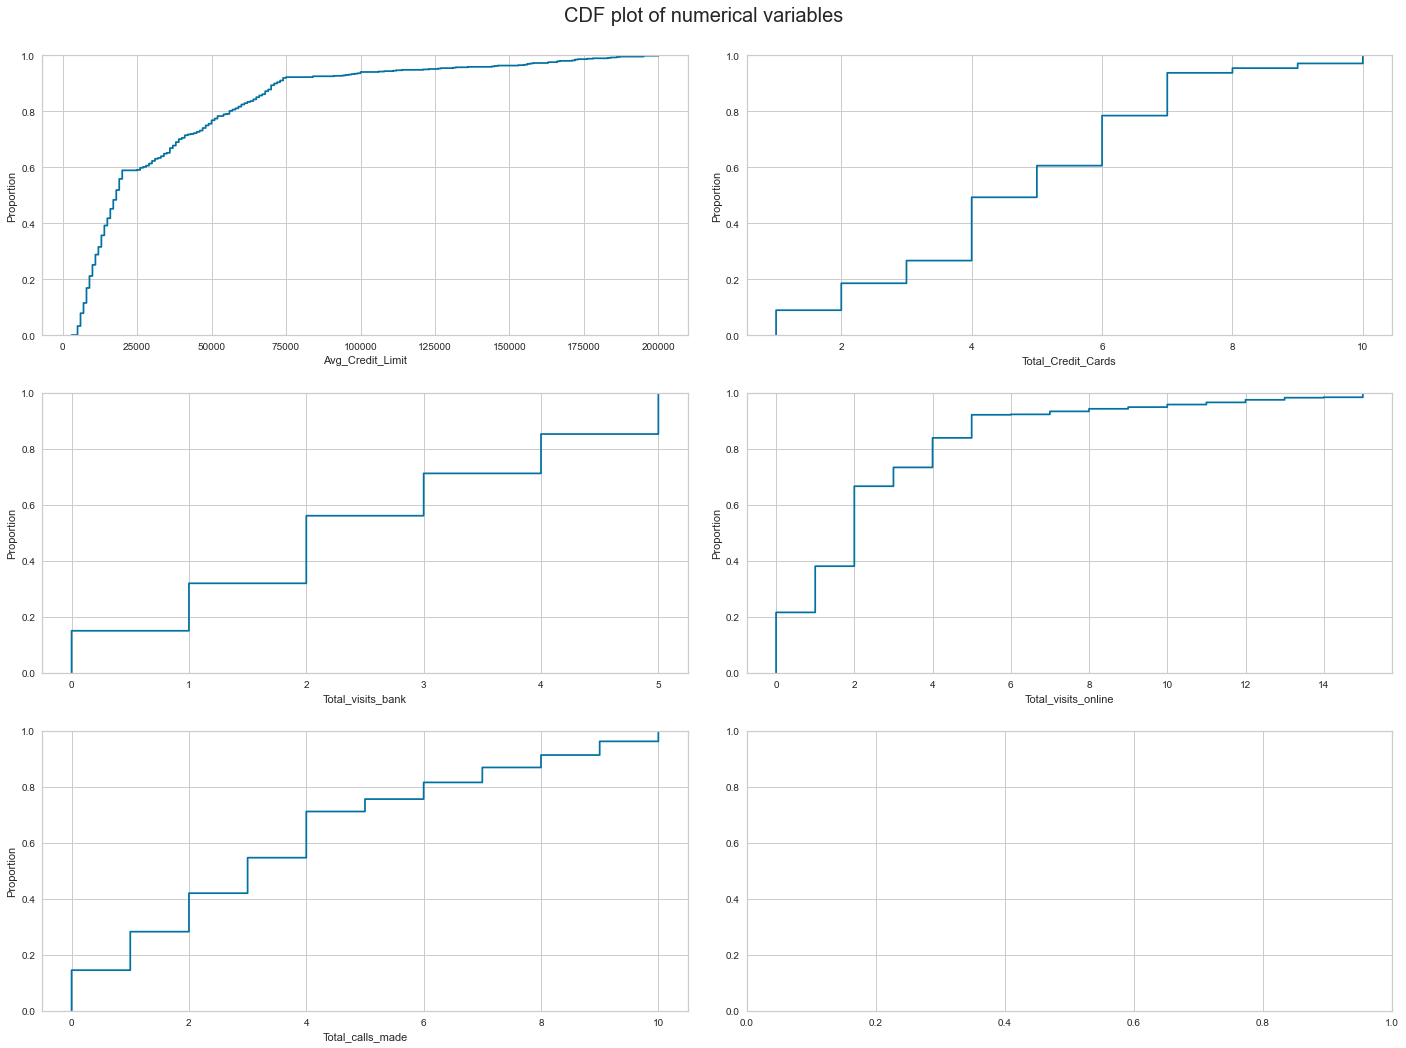

In [16]:
fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass

fig.tight_layout(pad=2.0)

- 80% of the customers have average credit limit of less than 75000
- 20% of the customers have more than 6 credit cards.
- 20% of the customers visit the bank more than 4 times.
- 20% of the customers visit online more than 4 times.
- 20% of the customer make more than 6 calls.

In [17]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

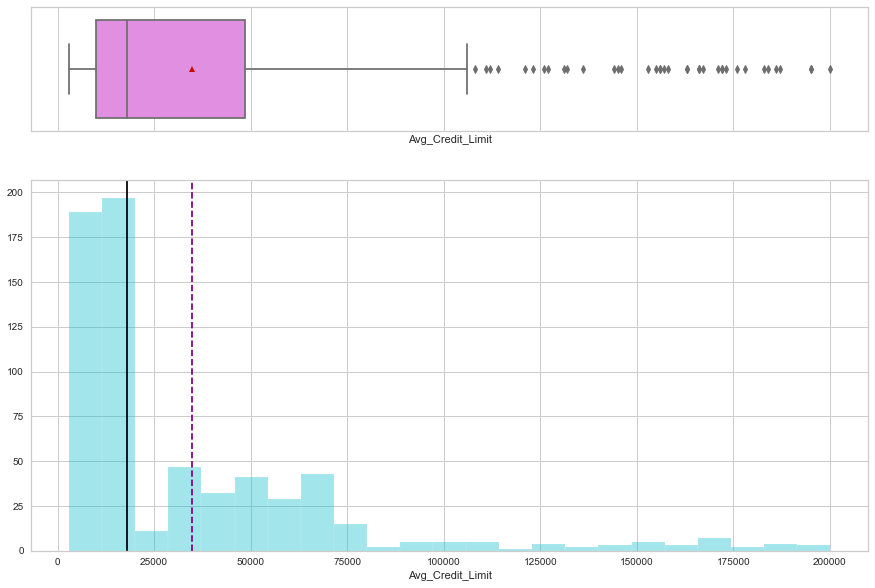

In [18]:
histogram_boxplot(df["Avg_Credit_Limit"])

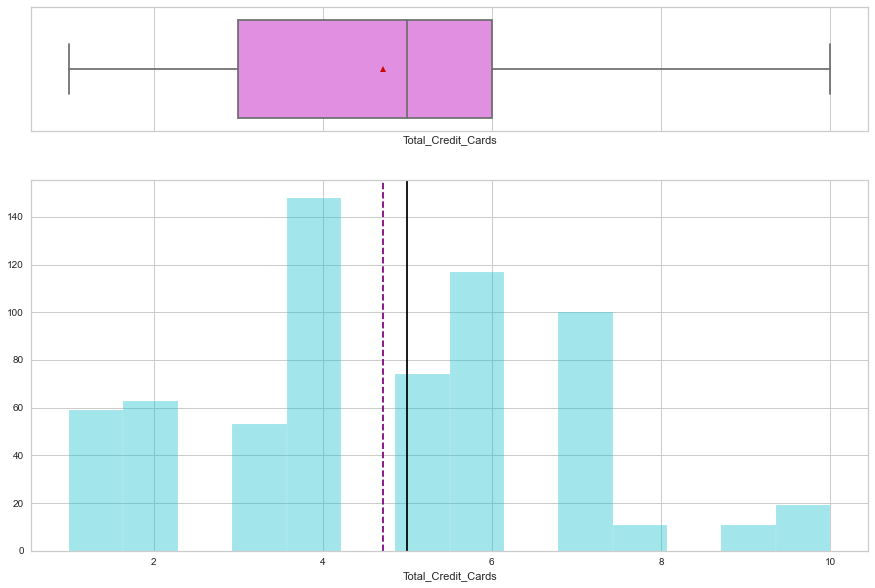

In [19]:
histogram_boxplot(df["Total_Credit_Cards"])

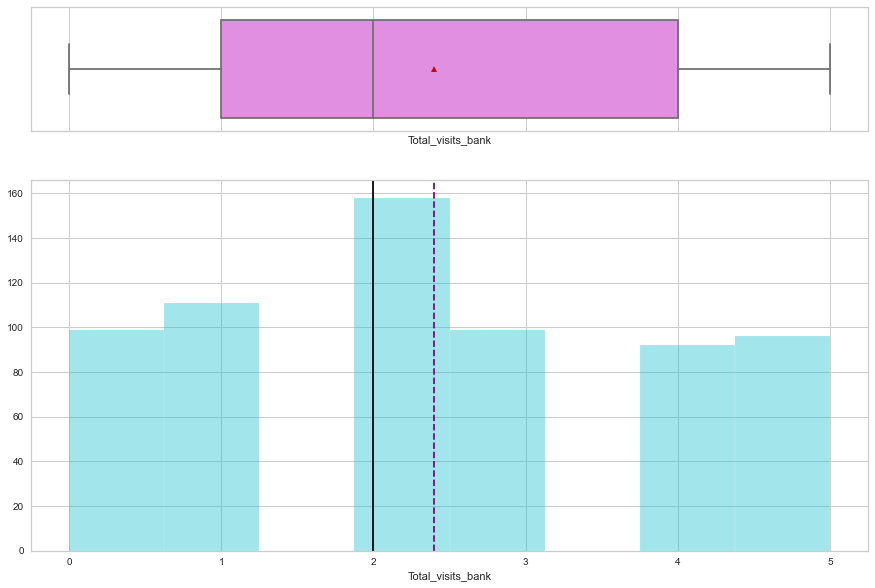

In [20]:
histogram_boxplot(df["Total_visits_bank"])

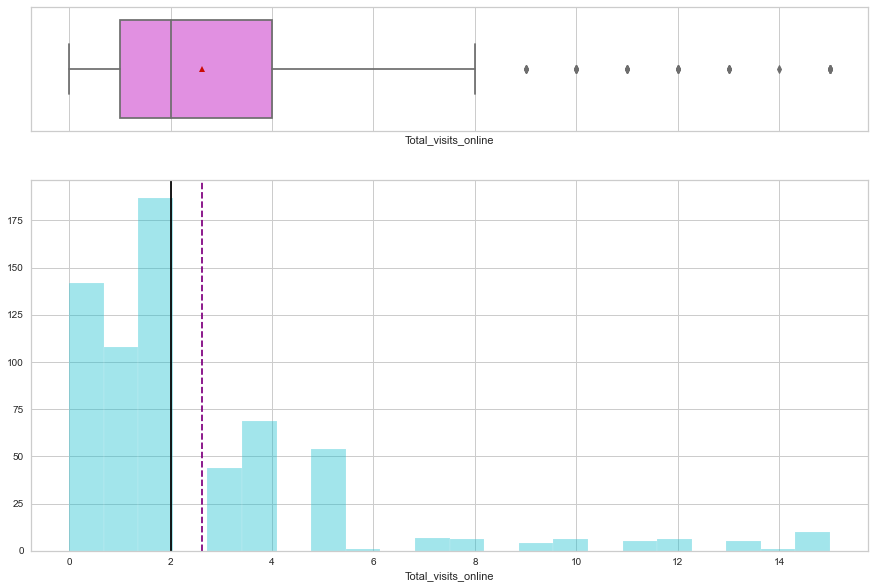

In [21]:
histogram_boxplot(df["Total_visits_online"])

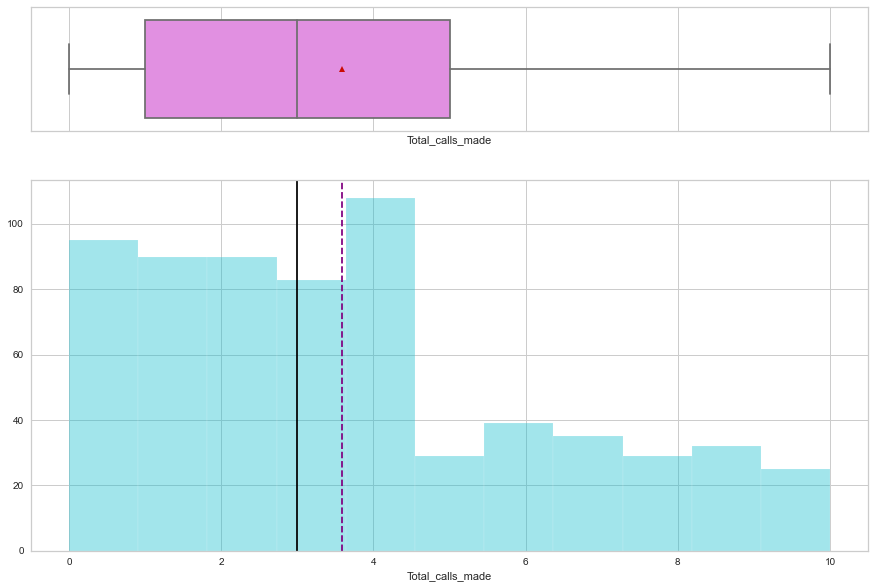

In [22]:
histogram_boxplot(df["Total_calls_made"])

**Observations**
- There are upper outliers in the average credit limit, which indicates there are customers with high credit limits.
- Total # of credit cards, visits to the bank and calls made seems to be distributed.
- Total Visit online seems to have some outliers.

### Bivariate Analsysis

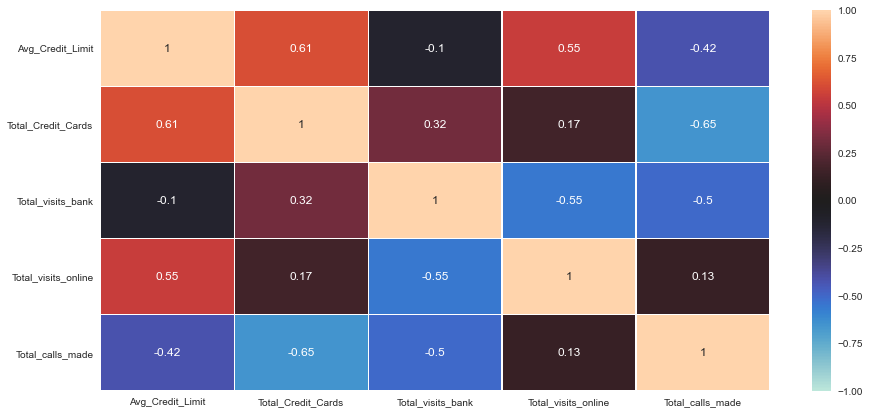

In [23]:
plt.figure(figsize=(15,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)

plt.show()

- There is a positive corelation between Total_visits_online and Avg_Credit_Limit (higher the average credit limit, the number of visits online is high)
- There is a positive corelation between Total_Credit_Cards and Avg_Credit_Limit (higher the average credit limit, they have more credit cards)
- There is a negative corelation between Total_Credit_Cards and Total_calls_made (higher the total number of credits, lower the total calls made)
- There is a negative corelation between Total_visits_bank and Total_calls_made (higher the visits to the bank, lower the calls made)

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Total_calls_made'>

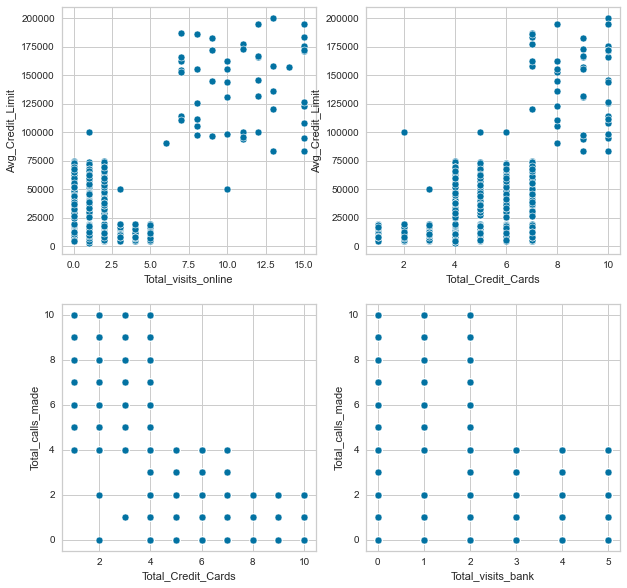

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(ax=axes[0,0],data=df, x='Total_visits_online',y='Avg_Credit_Limit')
sns.scatterplot(ax=axes[0,1],data=df, x='Total_Credit_Cards',y='Avg_Credit_Limit')
sns.scatterplot(ax=axes[1,0],data=df, x='Total_Credit_Cards',y='Total_calls_made')
sns.scatterplot(ax=axes[1,1],data=df, x='Total_visits_bank',y='Total_calls_made')

- We can clearly see that higher the visits online higher the average credit limit is.
- We can clearly see that higher the number of credit cards higher the average credit limit is.
- We can clearly see that higher the number of credit cards lower the number of calls made
- We can clearly see that higher the total number of visits to the bank lower is the calls made.

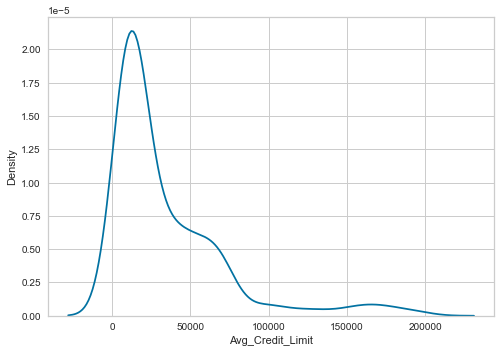

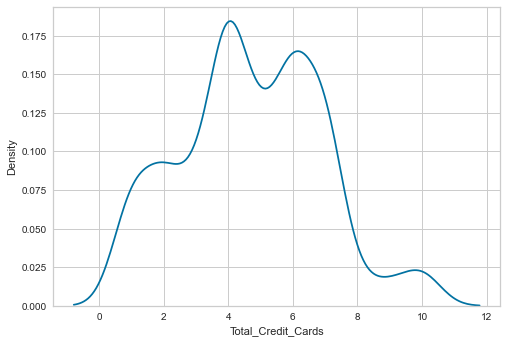

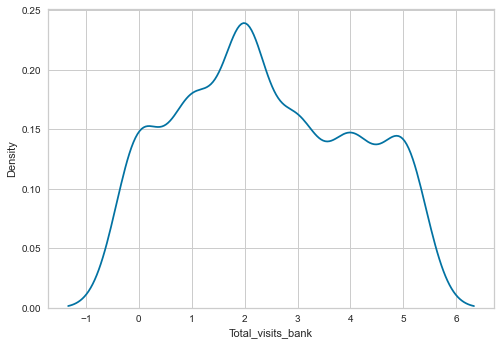

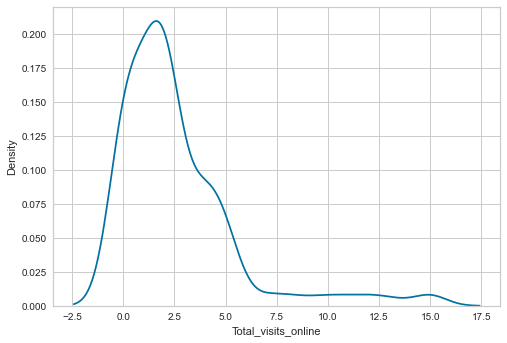

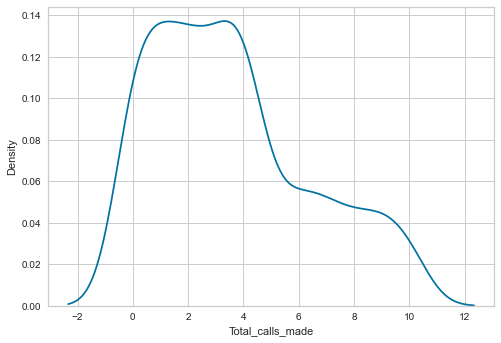

In [25]:
for i in all_col:
    sns.distplot(df[i],hist=False,)
    plt.show()

- We can see 3 clusters with average credit limit
- We can see 4 clusters with total credit cards
- we can see 3 clusters with total visits bank
- We can see around 3 clusters for total visits online and total calls made

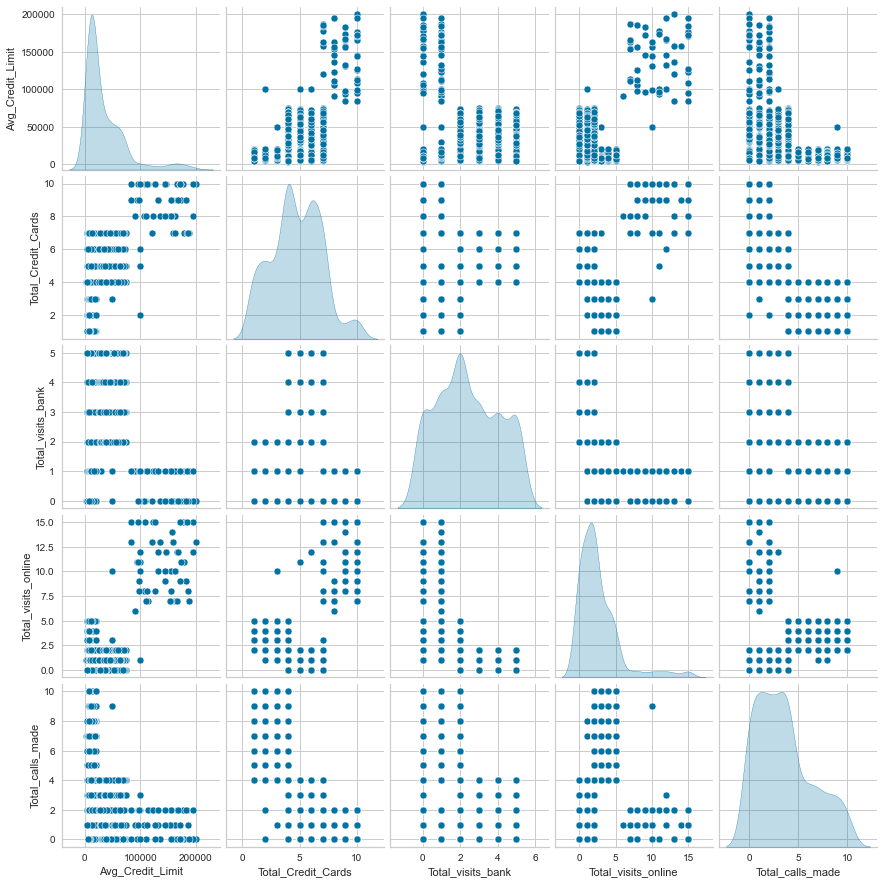

In [26]:
sns.pairplot(df[all_col],diag_kind="kde")

**Observations**
- Average_Credit_Limit can see 2/3 visible peaks
- total credit cards around 4 peaks
- 3 peaks for total bank visits, total visits online and total calls made.

# K-Means Clustering

## scaling data using standard scaler

In [27]:
# Scaling the data set before clustering
scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled=scaler.fit_transform(subset)   
subset.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


## Creating a dataframe from the scaled data

In [28]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.732369,-1.249105,-0.860646,-0.550400,-1.256040
1,0.406101,-0.788168,-1.475392,2.510549,1.901468
2,0.406101,1.055582,-0.860646,0.129811,0.147297
3,-0.124406,0.133707,-0.860646,-0.550400,0.147297
4,1.732369,0.594644,-1.475392,3.190759,-0.203537


## For different clusters using the euclidean, chebshev, mahalanobis and cityblock distance to find out the average distortion

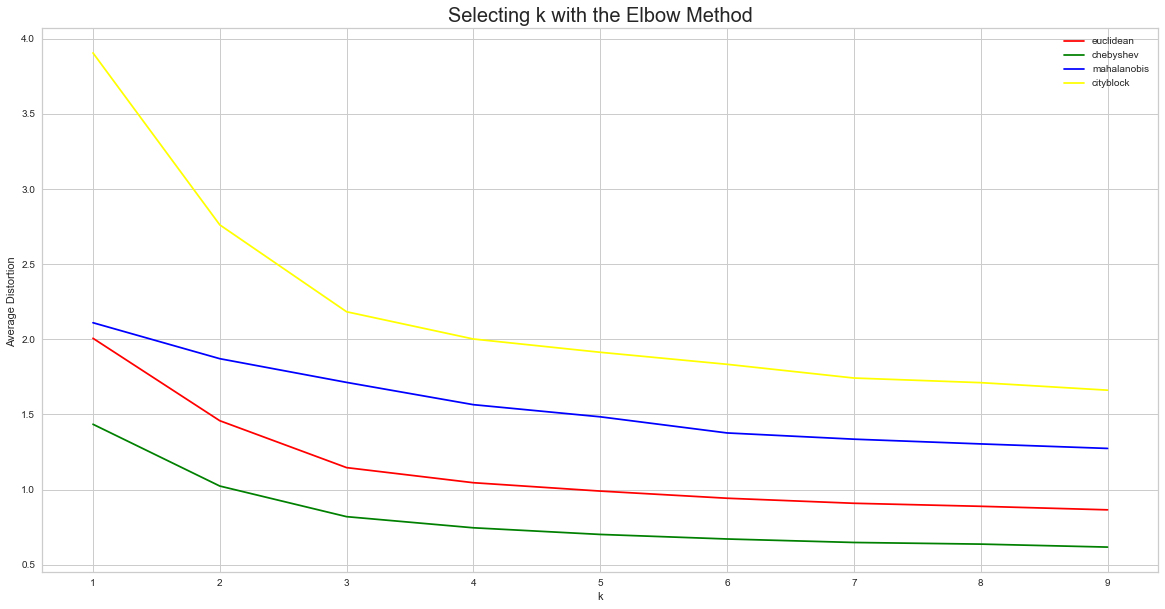

In [29]:
clusters=range(1,10)

distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
color=['red','green','blue','yellow']
i=0
avgDistortions=[]
plt.rcParams["figure.figsize"] = (20,10)
for dm in distance_metrics:
    meanDistortions=[]
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(subset_scaled_df)
        prediction=model.predict(subset_scaled_df)
        distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, dm), axis=1)) / subset_scaled_df.shape[0]
                           
        meanDistortions.append(distortion)
        avgDistortions.append([dm,k,distortion])
        #print('Number of Clusters:', k, dm,'\tAverage Distortion:', distortion)
    plt.plot(clusters, meanDistortions, 'bx-',color=color[i],label=dm)
    plt.xlabel('k')
    plt.ylabel('Average Distortion ')
    plt.title('Selecting k with the Elbow Method', fontsize=20)
    plt.legend()
    i=i+1

- Elbow methods with different distances show k value to be between 3 and 5.

In [30]:
pd.DataFrame(avgDistortions,columns=['Metric','# Cluster','Avg Distortion'])

,Metric,# Cluster,Avg Distortion
0,euclidean,1,2.006907
1,euclidean,2,1.458498
2,euclidean,3,1.146443
3,euclidean,4,1.046000
4,euclidean,5,0.990412
5,euclidean,6,0.942804
6,euclidean,7,0.909239
7,euclidean,8,0.889108
8,euclidean,9,0.865640
9,chebyshev,1,1.434918


## Finding the Silhouette Score with differene distance metrics

For n_clusters = 2, metric = euclidean, silhouette score is 0.41772421031246804)
For n_clusters = 3, metric = euclidean, silhouette score is 0.5154656016308689)
For n_clusters = 4, metric = euclidean, silhouette score is 0.35575668204686567)
For n_clusters = 5, metric = euclidean, silhouette score is 0.27234853662785014)
For n_clusters = 6, metric = euclidean, silhouette score is 0.2564807597114939)
For n_clusters = 7, metric = euclidean, silhouette score is 0.24983830907126095)
For n_clusters = 8, metric = euclidean, silhouette score is 0.22677649262457797)
For n_clusters = 9, metric = euclidean, silhouette score is 0.22474324023634223)
For n_clusters = 10, metric = euclidean, silhouette score is 0.20831480268301733)
For n_clusters = 11, metric = euclidean, silhouette score is 0.216038532944505)
For n_clusters = 12, metric = euclidean, silhouette score is 0.21012585268470924)
For n_clusters = 13, metric = euclidean, silhouette score is 0.21756132135587367)
For n_clusters = 14, metric 

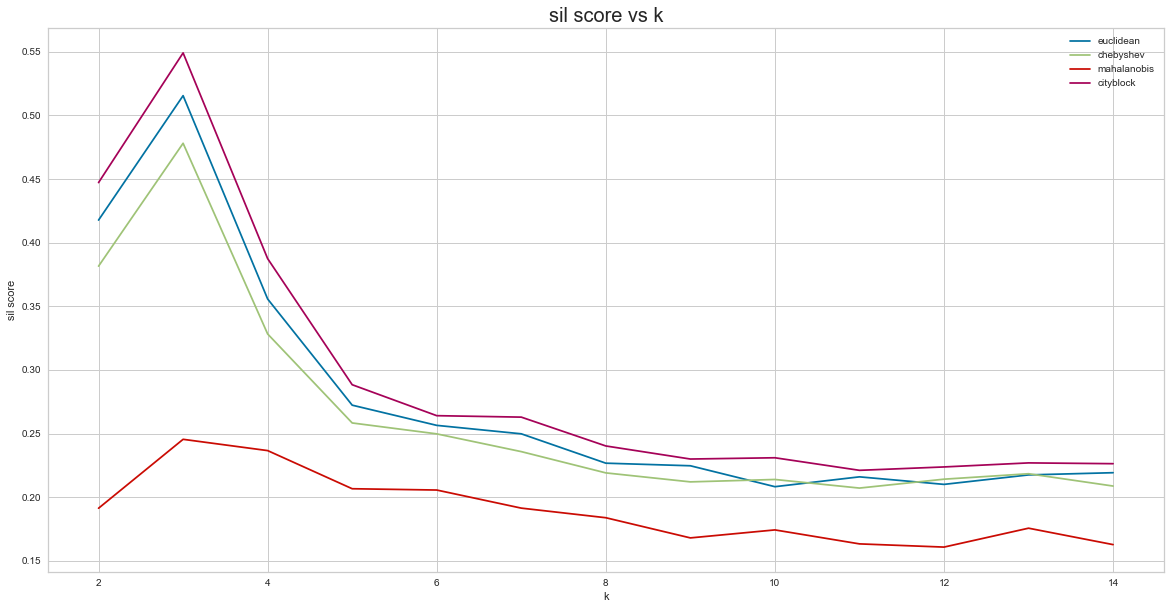

In [31]:

cluster_list = list(range(2,15))
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
for dm in distance_metrics:
    sil_score = []
    for n_clusters in cluster_list:
        clusterer = KMeans(n_clusters=n_clusters)
        preds = clusterer.fit_predict((subset_scaled_df))
        #centers = clusterer.cluster_centers_
        score = silhouette_score(subset_scaled_df, preds,metric=dm)
        sil_score.append(score)
        print("For n_clusters = {}, metric = {}, silhouette score is {})".format(n_clusters, dm,score))
    print("-" * 30)
    plt.plot(cluster_list,sil_score,label=dm)
    plt.xlabel('k')
    plt.ylabel('sil score')
    plt.title('sil score vs k', fontsize=20)
    plt.legend()
    plt.grid()

- With all the different distance metrics we are seeing for k=3 we have the highest silhouette score.
- Cityblock has the highest score of 0.55 followed by euclidean with 0.51

## #Finding optimal no. of clusters with silhouette coefficients

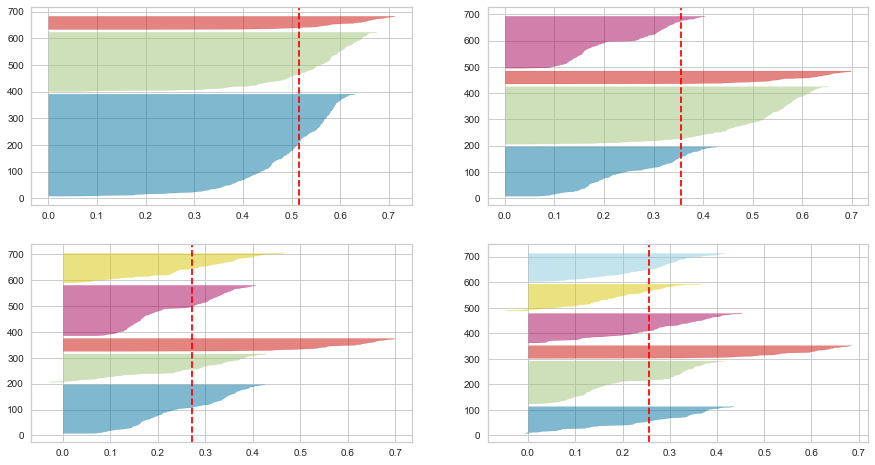

In [32]:
#Finding optimal no. of clusters with silhouette coefficients
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [3,4,5,6]:
    km = KMeans(i,random_state=1)
    q, mod = divmod(i-1, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(subset_scaled_df) 

- Looking at this the value of number of clusters as 5 and 6 looks to be sub optimal as the silhouette score looks very low.
- The value of 3 and 4 looks to be the optimal one as compared to others this has a high silhouette score and also the silhouette score for each cluster is above average silhouette score

## Let us proceed with 3, 4 clusters and see how the clusters come up

In [33]:
%%time
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

CPU times: user 64.1 ms, sys: 12.4 ms, total: 76.5 ms
Wall time: 46.1 ms


KMeans(n_clusters=3, random_state=1)

In [34]:
df_kmeans['K_means_segments'] = kmeans.labels_

In [35]:
cluster_profile_kmeans = df_kmeans.groupby('K_means_segments').mean()

In [36]:
#cluster_profile_kmeans['count_in_each_segment'] = df_kmeans.groupby('K_means_segments')['Total_Credit_Cards'].count().values
cluster_profile_kmeans['count_in_each_segment'] = df_kmeans.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [37]:
cluster_profile_kmeans

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,54801.882507,33853.785901,5.519582,3.483029,0.986945,2.010444,383
1,55128.536036,12180.180180,2.405405,0.936937,3.567568,6.851351,222
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


- Cluster 2 we can see the average credit limit and total number of credit cards and total visits online is high compared to the other clusters.
- Cluster 0 we can see their visits to the bank is high
- Cluster 1 we can see total calls they are making is high compared to other clusters.

<AxesSubplot:xlabel='K_means_segments'>

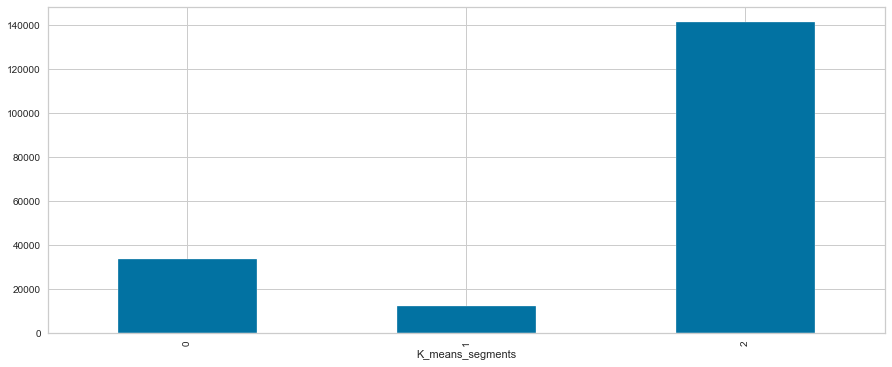

In [38]:
df_kmeans.groupby('K_means_segments')['Avg_Credit_Limit'].mean().plot.bar(figsize=(15,6))

- Average Credit Limit is high for cluster 2

<AxesSubplot:xlabel='K_means_segments'>

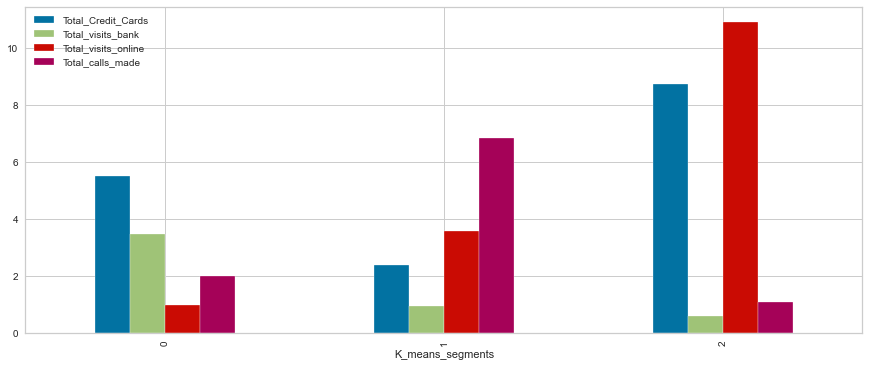

In [39]:
df_kmeans.groupby('K_means_segments')['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made'].mean().plot.bar(figsize=(15,6))

- Total # of credit cards and Total visits online are high for cluster 2.
- Total calls made is high for cluster 1
- Total credit cards is higher for cluster 0 compared to cluster 1, but less than cluster 2.
- Total Visits to the bank is high for cluster 0 compared to other clusters.

In [40]:
pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_Credit_Cards']).style.highlight_max(color = 'green', axis = 0)

Total_Credit_Cards,1,2,3,4,5,6,7,8,9,10
K_means_segments,,,,,,,,,,
0,0,1,0,100,73,116,93,0,0,0
1,59,62,53,48,0,0,0,0,0,0
2,0,0,0,0,1,1,7,11,11,19


- Total number of credit cards for cluster 2 is 7 or more
- Total number of credit cards for cluster 1 is 4 or less
- Total number of credit cards for cluster 0 is b/w 4 to 6

In [41]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_Credit_Cards']).plot(kind='bar',stacked=True)

In [42]:
pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_bank']).style.highlight_max(color = 'green', axis = 0)

Total_visits_bank,0,1,2,3,4,5
K_means_segments,,,,,,
0,0,3,93,99,92,96
1,79,78,65,0,0,0
2,20,30,0,0,0,0


- Cluster 0 customer prefer visitibank the bank more than other clusters

In [43]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_bank']).plot(kind='bar',stacked=True)

In [44]:
pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_online']).style.highlight_max(color = 'lightgreen', axis = 0)

Total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
K_means_segments,,,,,,,,,,,,,,,,
0,142,105,135,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,52,43,69,54,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


- Cluster 2 customers visit online more compared to other clusters (7+)
- Cluster 1 customers visit online b/w 2-5 times
- Cluster 0 customers have less online visits (<=2)

In [45]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_online']).plot(kind = 'bar', stacked=True)

In [46]:
pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_calls_made']).style.highlight_max(color = 'lightgreen', axis = 0)

Total_calls_made,0,1,2,3,4,5,6,7,8,9,10
K_means_segments,,,,,,,,,,,
0,79,74,71,82,77,0,0,0,0,0,0
1,0,1,1,0,31,29,39,35,29,32,25
2,16,15,18,1,0,0,0,0,0,0,0


- Cluster 0 also prefers to make fewer calls but higher than cluster 2
- Cluster 1 prefer to call up the bank compared to other clusters (>5)
- Cluster 2 make fewer calls to the bank comparitively (<3)

In [47]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_calls_made']).plot(kind = 'bar', stacked=True)

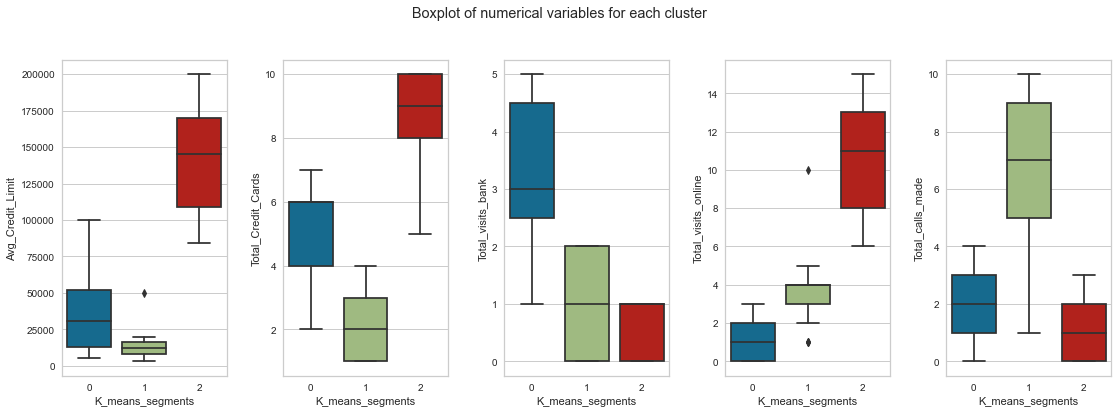

In [126]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df_kmeans[all_col[counter]],x=df_kmeans['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

- Cluster 2 are those customers with higher credit limit (avg 150000) having more card (avg 9 cards) with higher visits online compared to visiting banks / calls.
- Cluster 1 are customers with low credit limit (avg 12000 )having fewer cards ( avg 2 cards) with high number of calls to the bank compared to online or bank visits.
- Cluster 0 are customers with credit limit (33000 avg) with more cards (avg 5) with higher number of visits to the bank compared to calls or visits online

# Hierarchical Clustering

## For different linkage methods determine the cophenetic coefficient
  - Linkages used here : 'single', 'complete', 'average','weighted'
  - Distance Metrics used here : 'euclidean','chebyshev','mahalanobis','cityblock'

In [49]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average']

# Create lists to save results of coph calculation
compare_cols = ['Linkage','Metrics','Cophenetic Coefficient']
compare = []

high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
        print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        compare.append([lm, dm, c])
    print("---"*30)

Cophent correlation for distance metrics euclidean and linkage method single is 0.7391473713405818
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8758017442817639
Cophent correlation for distance metrics euclidean and linkage method average is 0.8971061215847376
------------------------------------------------------------------------------------------
Cophent correlation for distance metrics chebyshev and linkage method single is 0.7377009257150868
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.8626209788676898
Cophent correlation for distance metrics chebyshev and linkage method average is 0.8952075169385171
------------------------------------------------------------------------------------------
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.7060943811469491
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.6980459186344931
Cophent correl

In [50]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare,columns=compare_cols)
df_cc.sort_values(by='Cophenetic Coefficient',ascending=False)

,Linkage,Metrics,Cophenetic Coefficient
2,average,euclidean,0.897106
11,average,cityblock,0.895734
5,average,chebyshev,0.895208
1,complete,euclidean,0.875802
10,complete,cityblock,0.874453
4,complete,chebyshev,0.862621
8,average,mahalanobis,0.831912
0,single,euclidean,0.739147
3,single,chebyshev,0.737701
9,single,cityblock,0.725030


## For different linkage methods determine the cophenetic coefficient 
### Lets explore 'centroid','ward' linkage method which requires only Euclidean distance metrics
  - Linkages used here : 'centroid','ward'
  - Distance Metrics used here : 'euclidean'

In [51]:
linkage_methods = ['centroid','ward']
high1_cophenet_corr = 0
high1_dm_lm = [0,0]
compare = []
for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
    print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format('euclidean',lm,c))
    compare.append([lm,'euclidean',  c])

Cophent correlation for distance metrics euclidean and linkage method centroid is 0.8938725248289437
Cophent correlation for distance metrics euclidean and linkage method ward is 0.7416585017721558


In [52]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = df_cc.append(pd.DataFrame(compare,columns=compare_cols),ignore_index=True)
df_cc.sort_values(by='Cophenetic Coefficient',ascending=False)

,Linkage,Metrics,Cophenetic Coefficient
2,average,euclidean,0.897106
11,average,cityblock,0.895734
5,average,chebyshev,0.895208
12,centroid,euclidean,0.893873
1,complete,euclidean,0.875802
10,complete,cityblock,0.874453
4,complete,chebyshev,0.862621
8,average,mahalanobis,0.831912
13,ward,euclidean,0.741659
0,single,euclidean,0.739147


- Sort all the linkage method with highest cophenetic coefficient.

In [53]:
df_cc.sort_values(by='Cophenetic Coefficient',ascending=False).head(5)

,Linkage,Metrics,Cophenetic Coefficient
2,average,euclidean,0.897106
11,average,cityblock,0.895734
5,average,chebyshev,0.895208
12,centroid,euclidean,0.893873
1,complete,euclidean,0.875802


- We can see the top five cophenetic coefficients are as below
* average	euclidean	0.897106
* average	cityblock	0.895734
* average	chebyshev	0.895208
* centroid	euclidean	0.893873
* complete	euclidean	0.875802

## Let us look at the dendrogram for the different linkage methods.

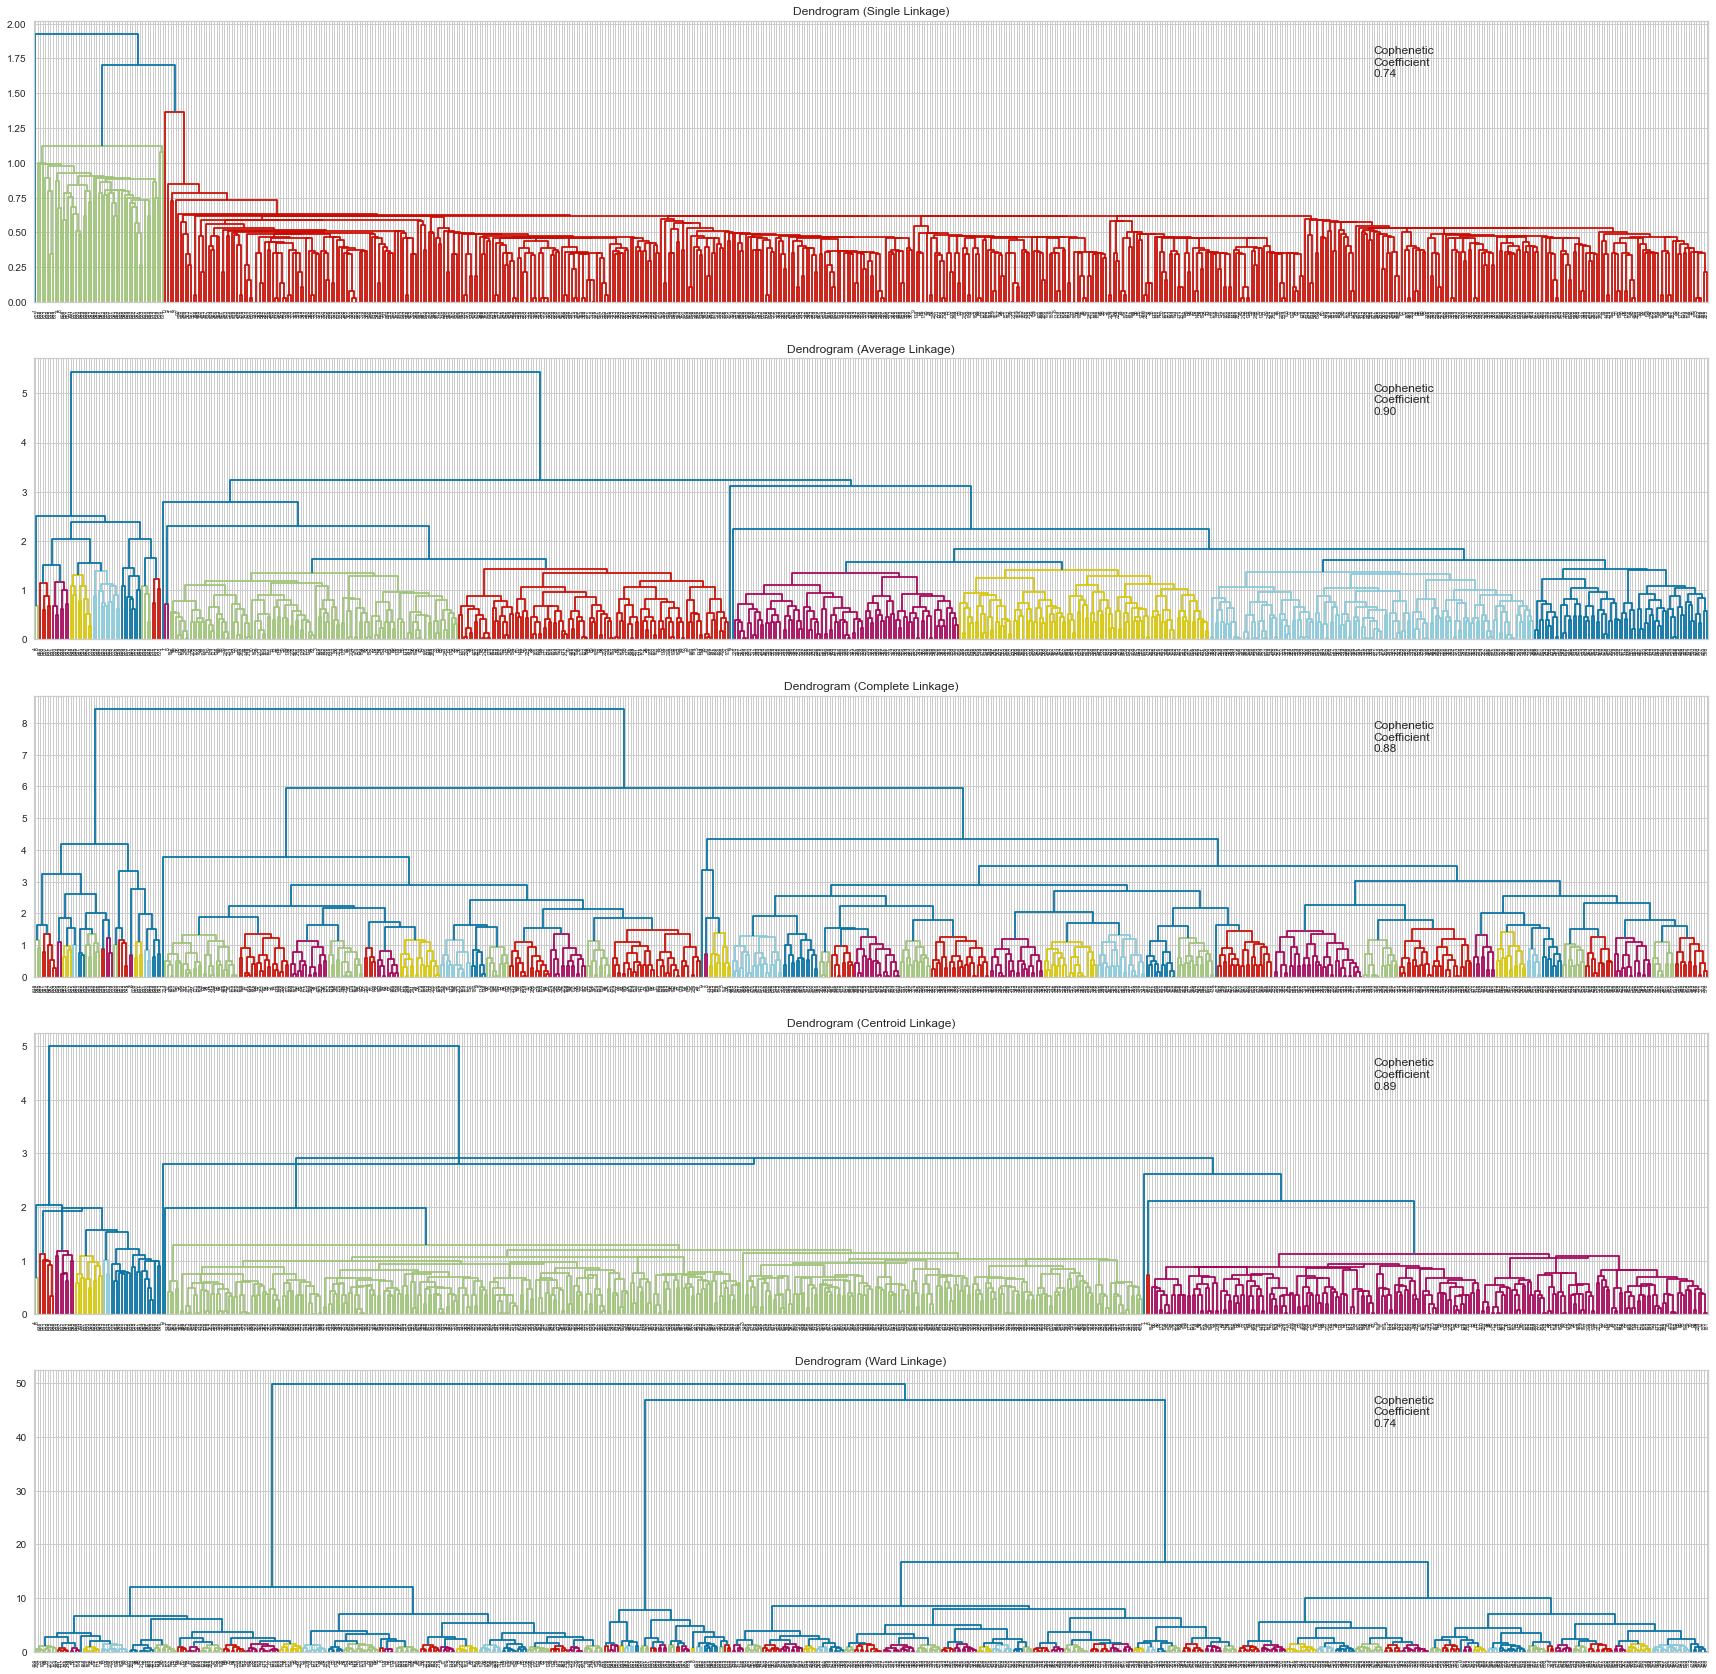

In [54]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward'
          ]

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)


# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(30, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i],color_threshold=1.5);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')

- When it comes to Euclidean distance : Average, complete has a clear dendrogram and visible separated clusters compared to others.

In [55]:
distance_metrics = [ 'chebyshev','mahalanobis','cityblock']
linkage_methods = ['complete','average']

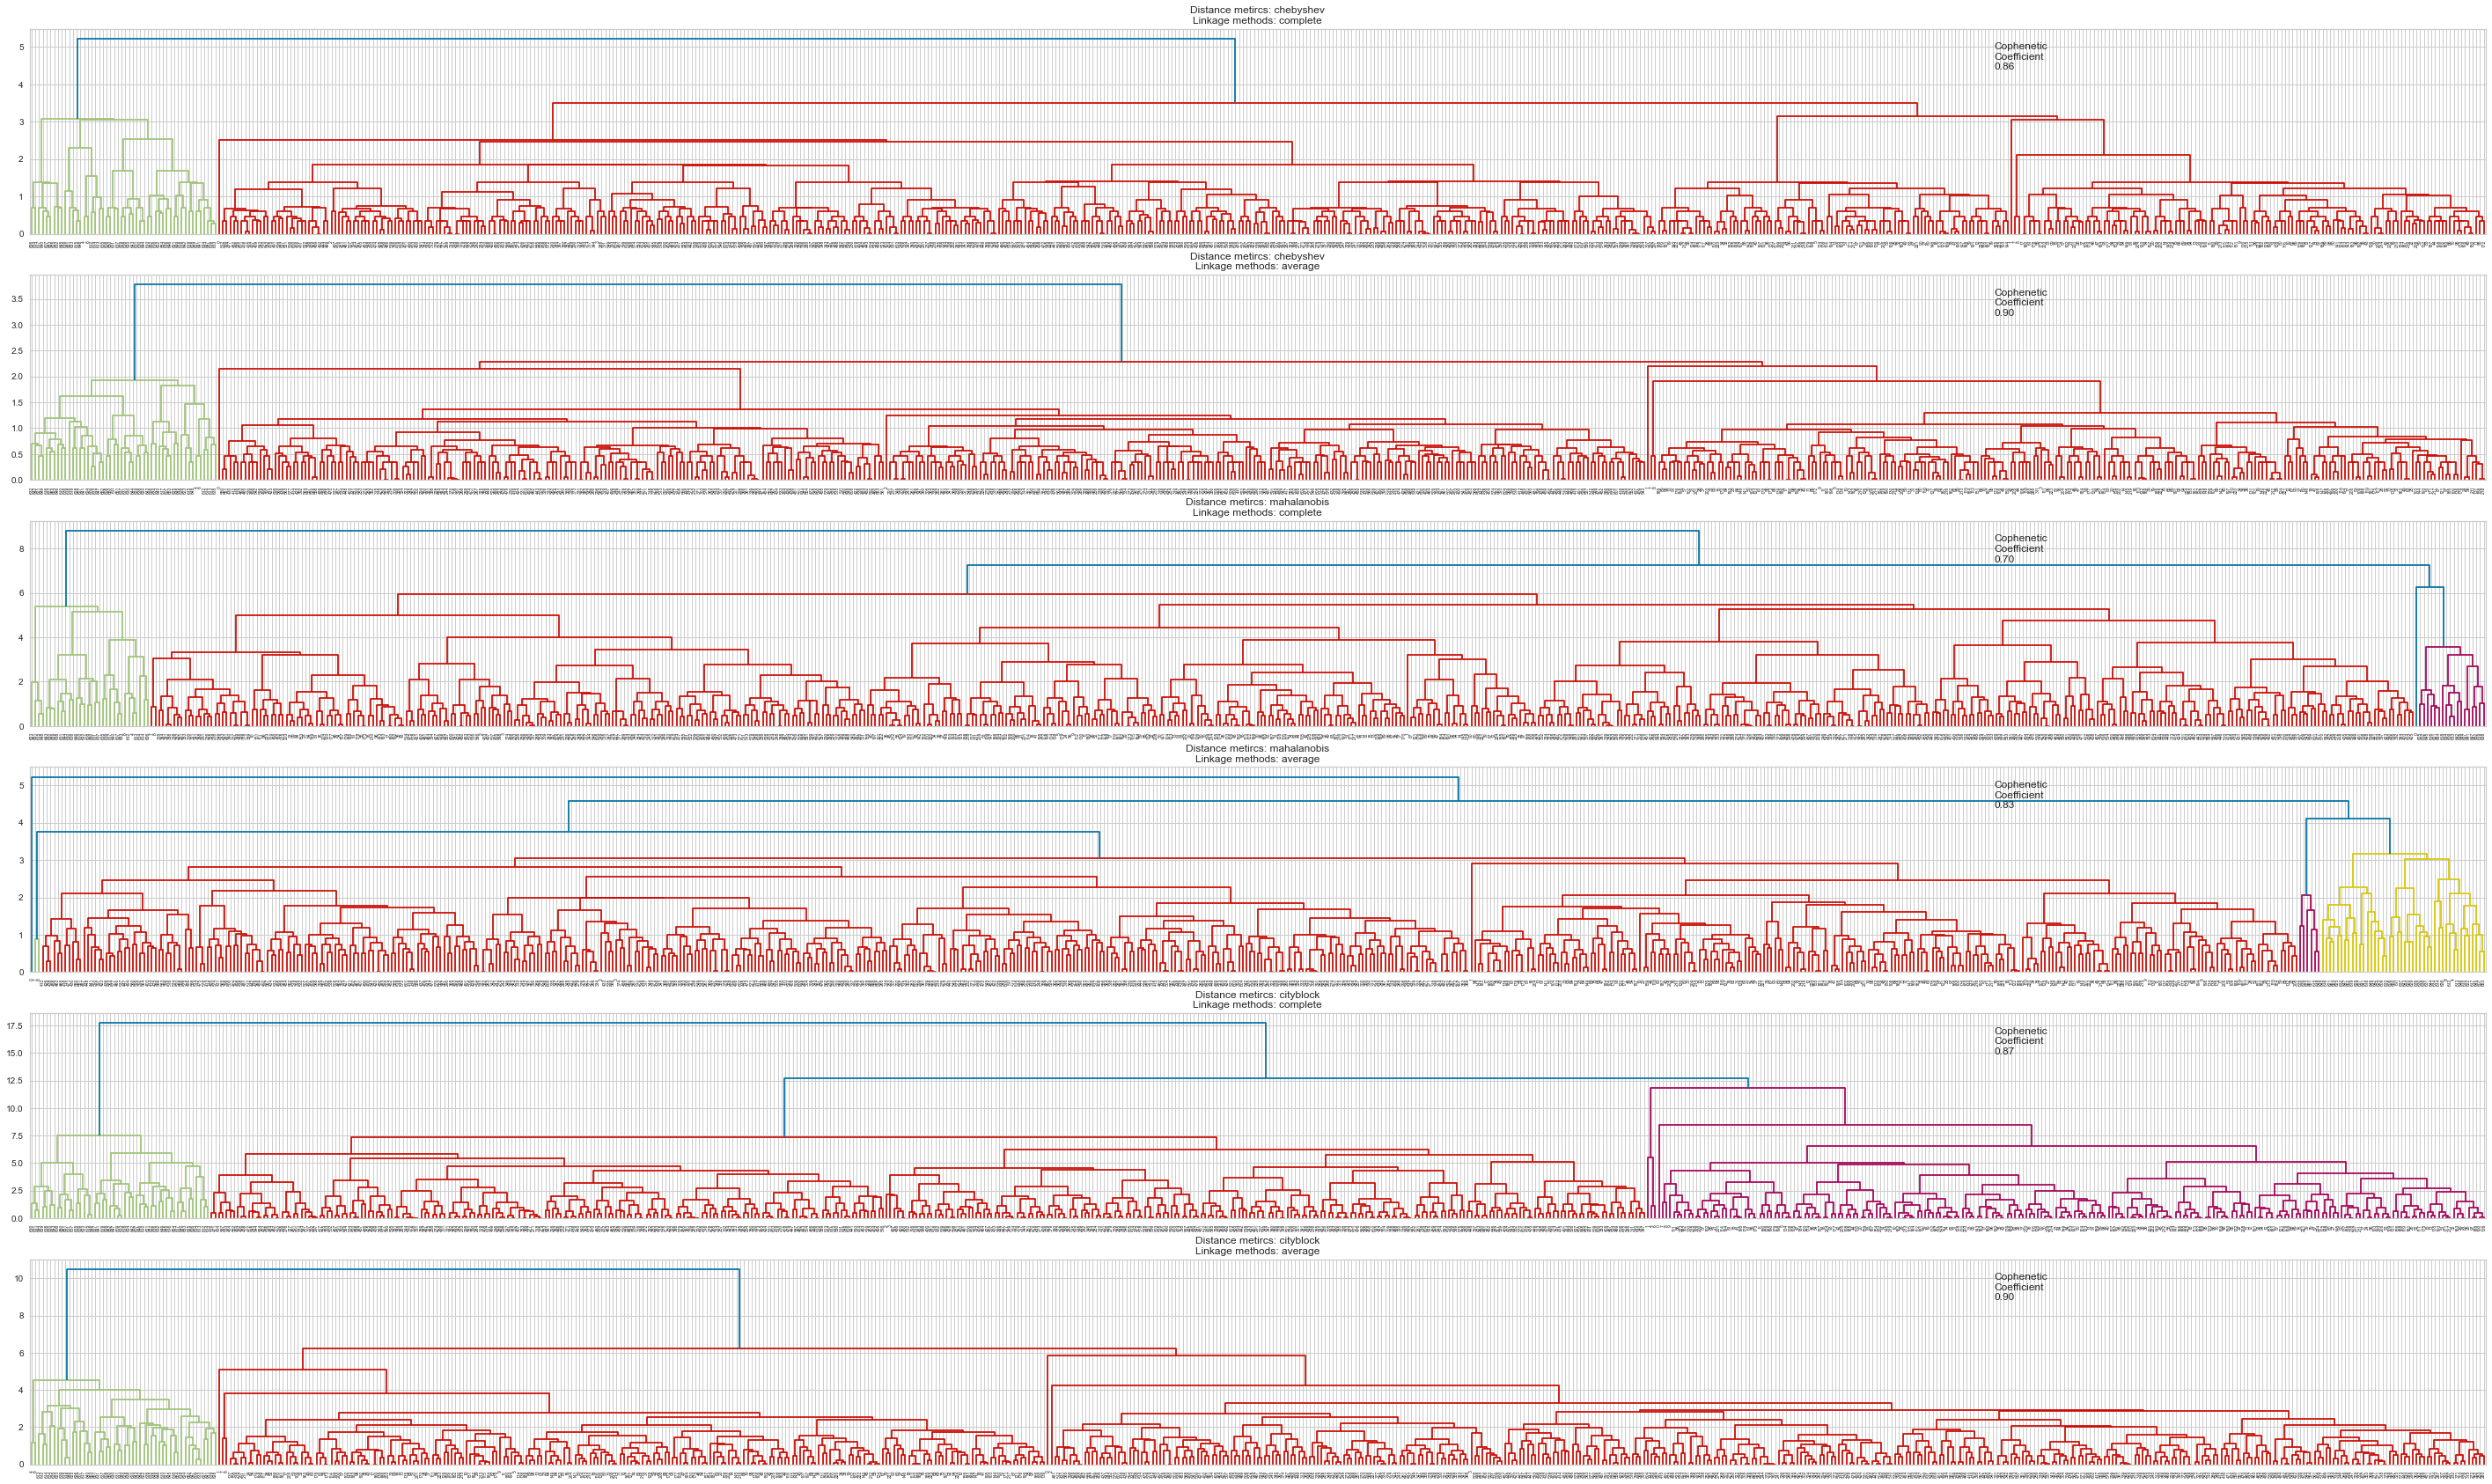

In [56]:
# Create a subplot image
fig, axs = plt.subplots(2*len(distance_metrics), 1, figsize=(50, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1

- From this group it looks like mahalanobis Complete and cityblock average are fairly distinct and clear

## For the clear and visible Dendrogram below chosen are the chosen ones
 
- Average and Euclidean
- Complete and Euclidean
- Complete and Mahalanabois
- Average and cityblock

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### Euclidean and Average

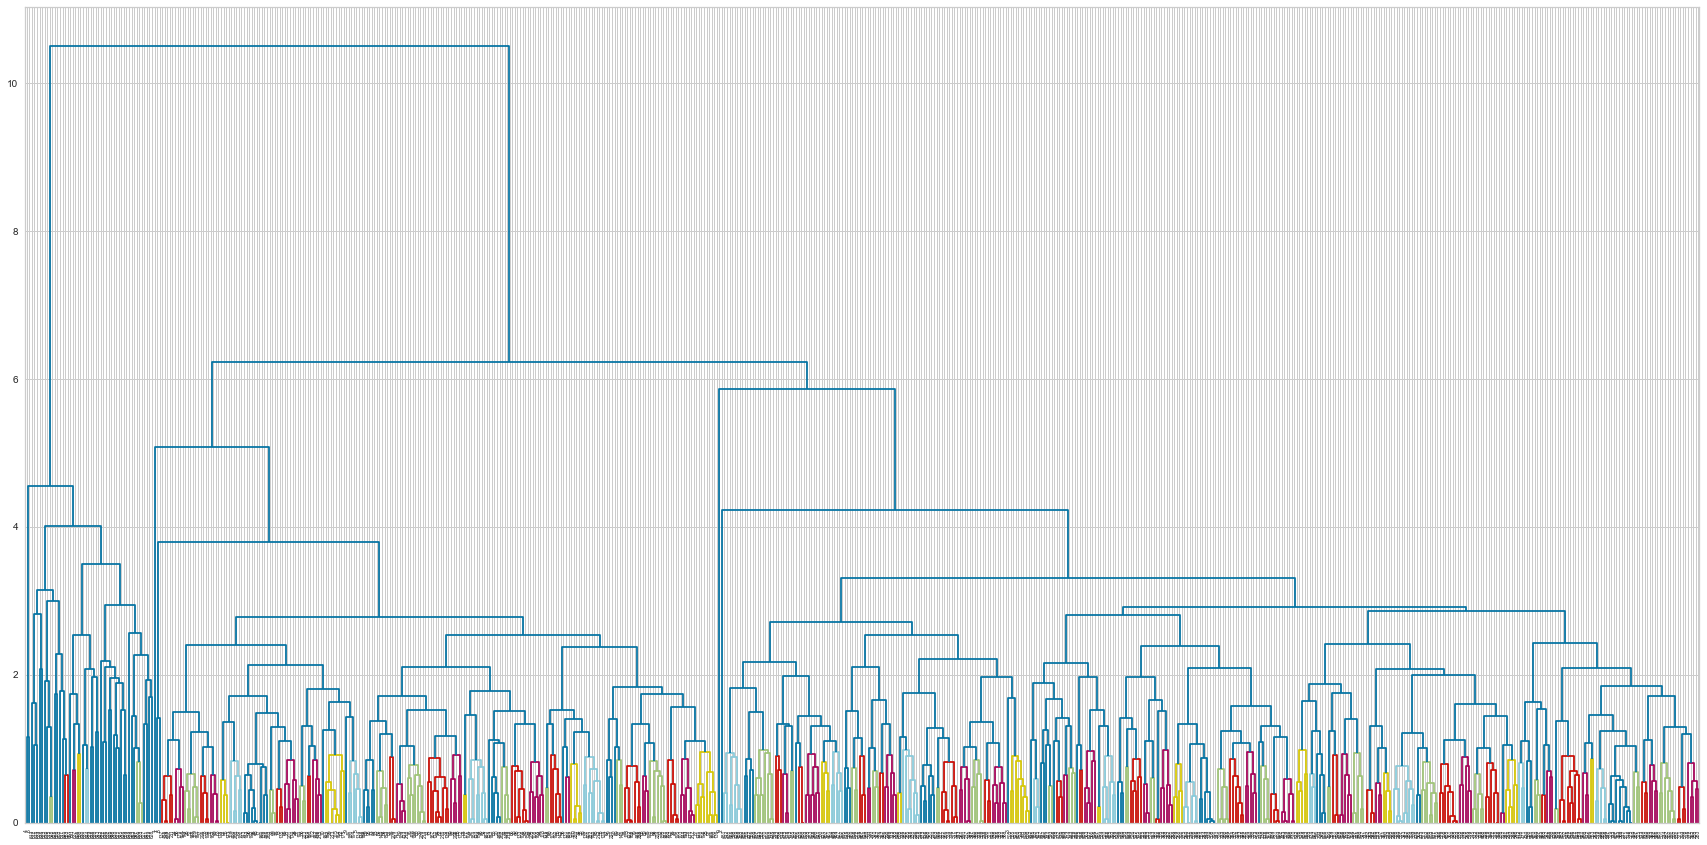

In [57]:
Z1 = linkage(subset_scaled_df, metric='euclidean', method='average')
plt.figure(figsize=(30, 15))
dendrogram(Z,color_threshold=1)
plt.show()

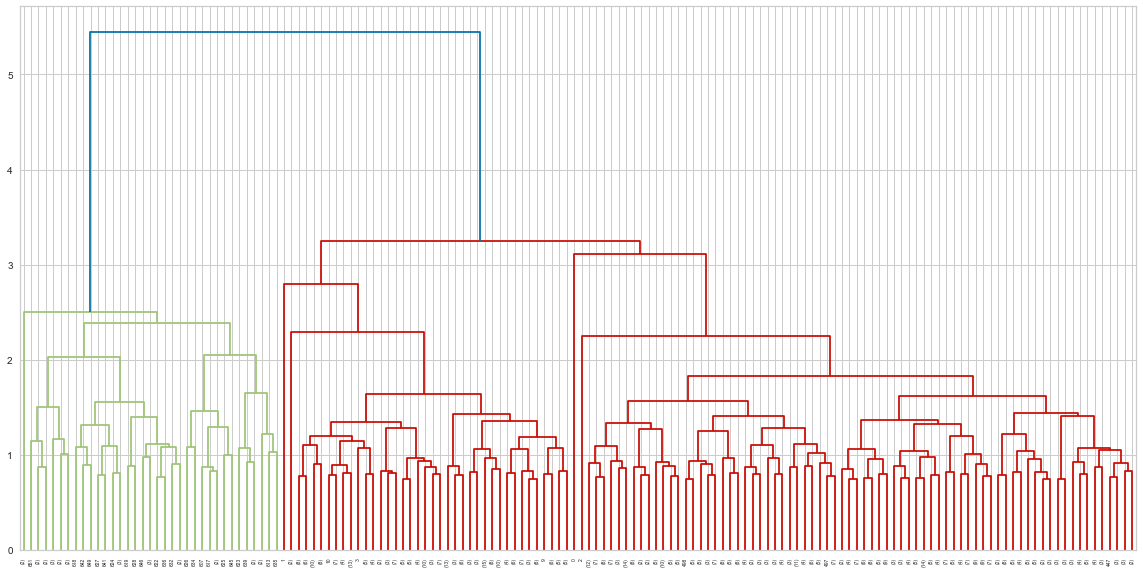

In [58]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z1,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [59]:
clusters1 = fcluster(Z1, 3.2, criterion='distance')
clusters1

array([3, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [60]:
# Calculate Avg Silhoutte Score
compare_silscore=[]
score1=silhouette_score(subset_scaled_df,clusters1)
compare_silscore.append(['Average','Euclidean',score1])

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### Cityblock and Average

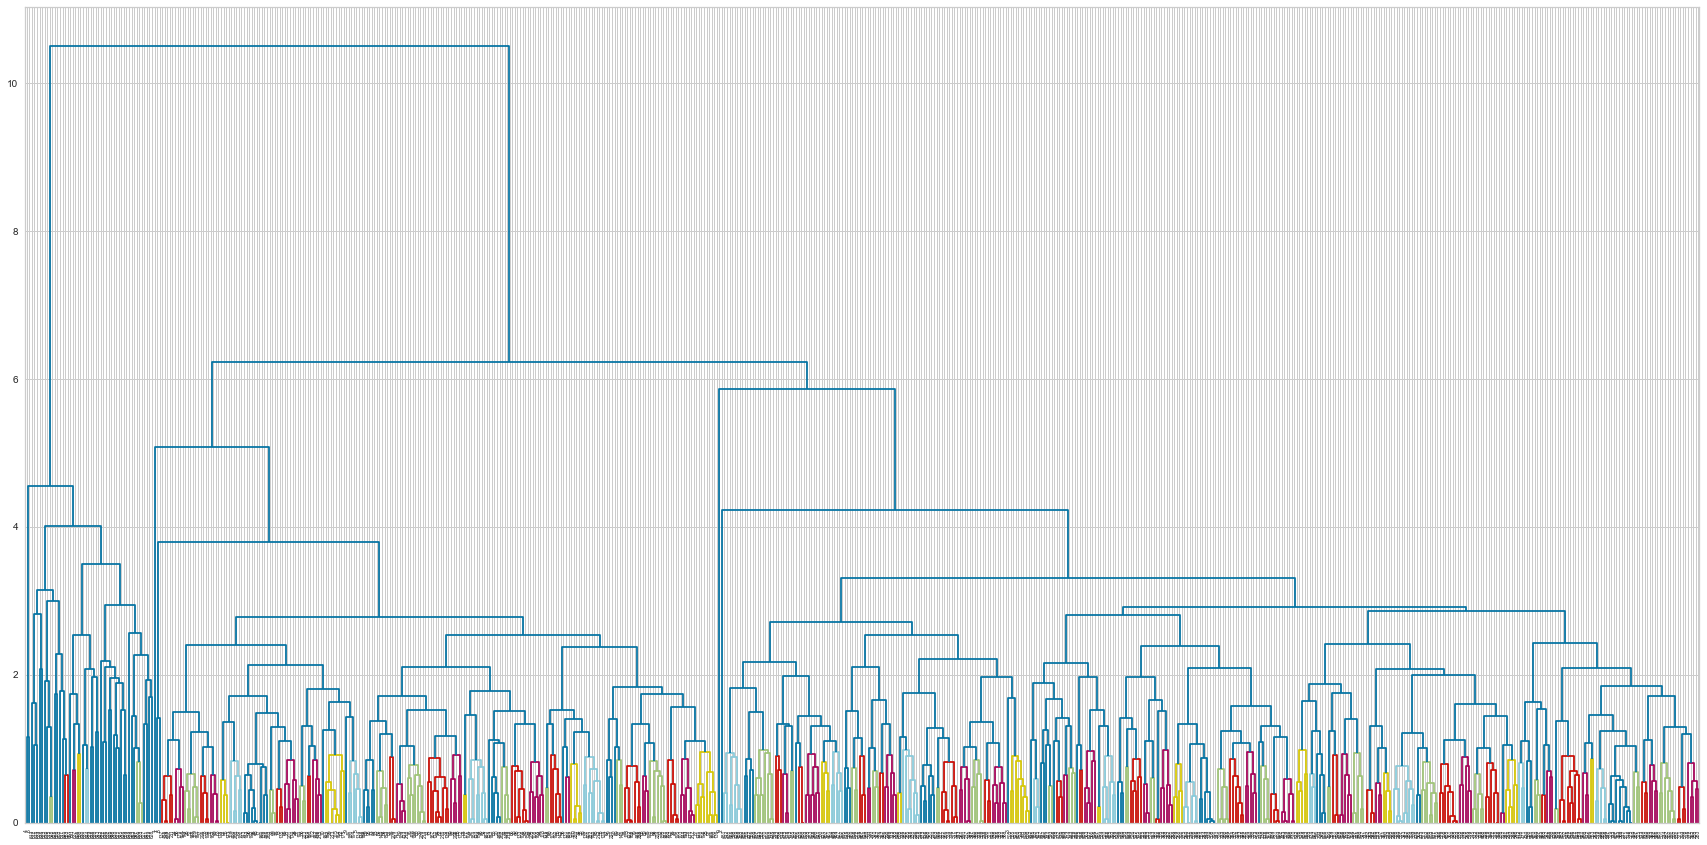

In [61]:
Z2 = linkage(subset_scaled_df, metric='cityblock', method='average')
plt.figure(figsize=(30, 15))
dendrogram(Z2,color_threshold=1)
plt.show()

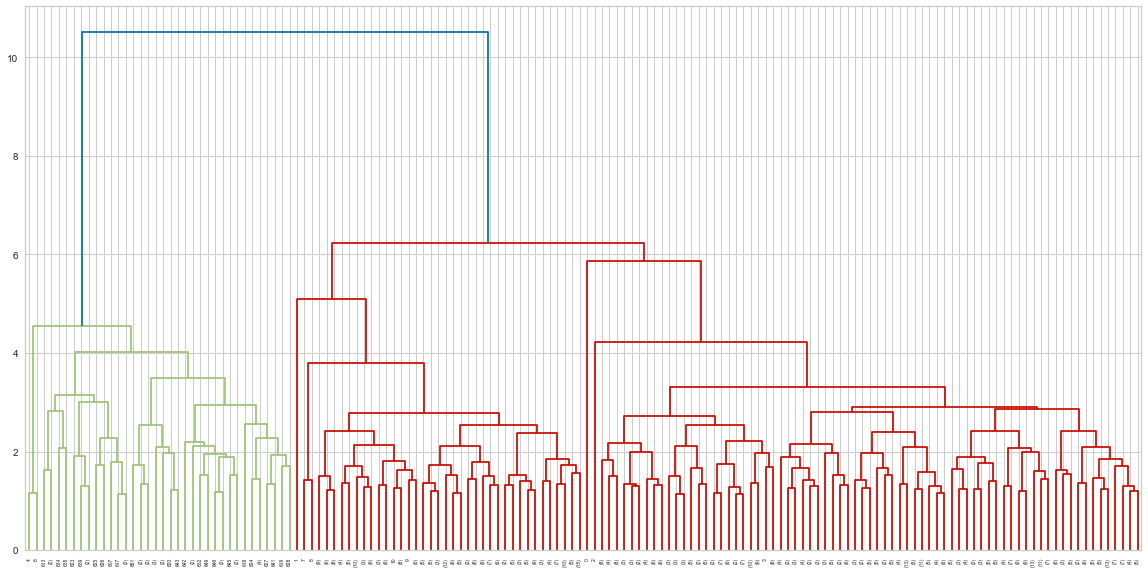

In [62]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z2,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [63]:
clusters2 = fcluster(Z2, 6, criterion='distance')
clusters2

array([3, 2, 3, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [64]:
# Calculate Avg Silhoutte Score
score2=silhouette_score(subset_scaled_df,clusters2)
compare_silscore.append(['Average','cityblock',score2])

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### Mahalanobis and Complete

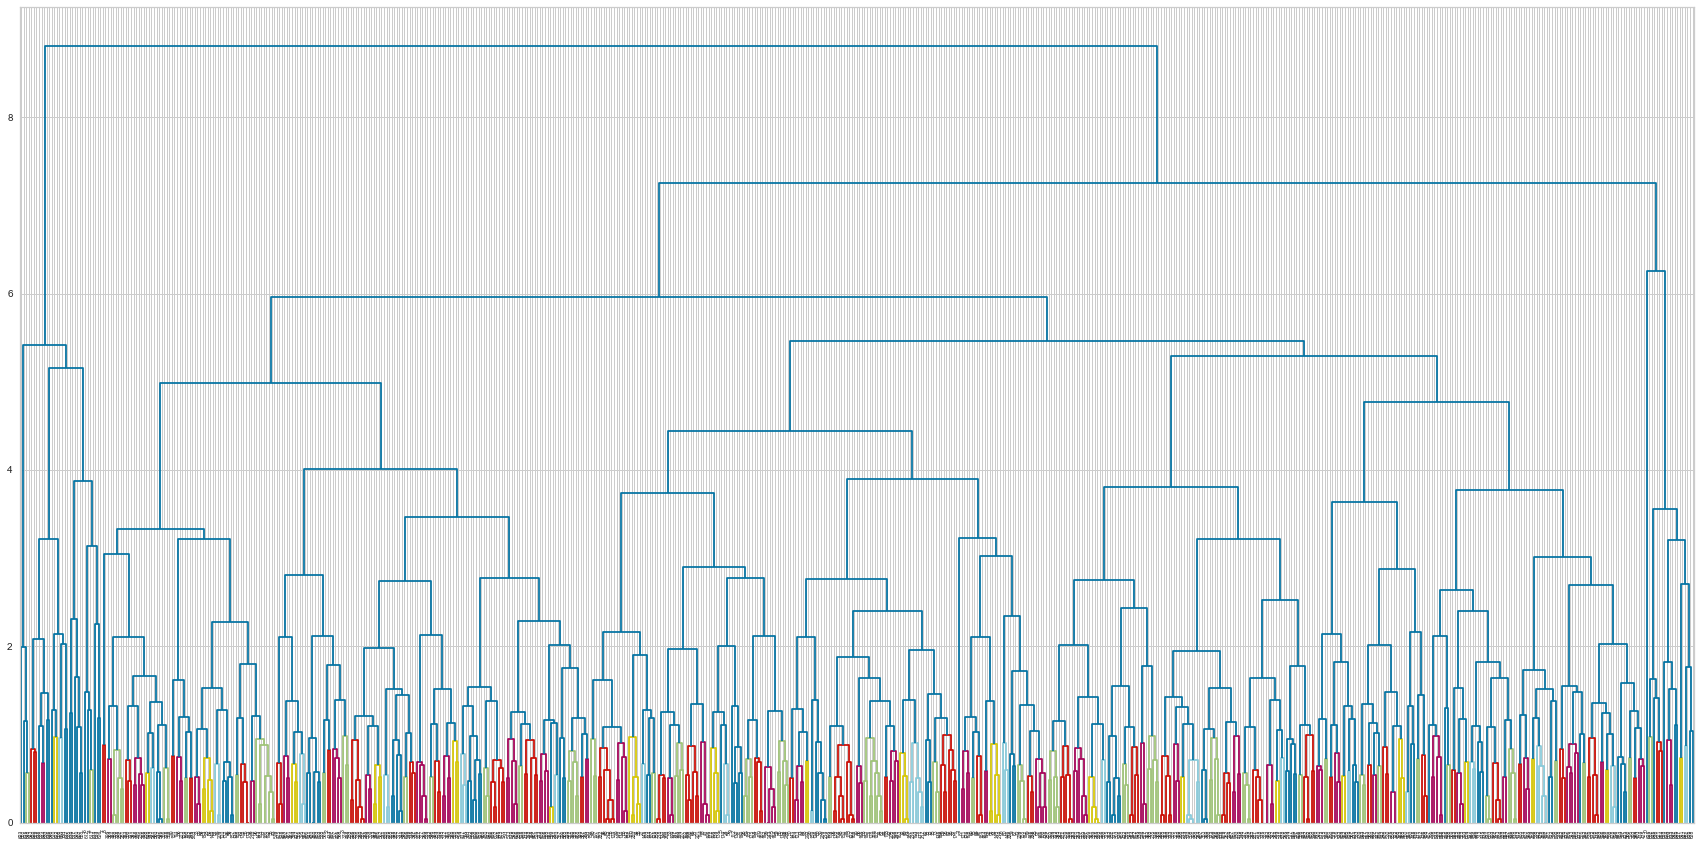

In [65]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
Z3 = linkage(subset_scaled_df, metric='mahalanobis', method='complete')
plt.figure(figsize=(30, 15))
dendrogram(Z3,color_threshold=1)
plt.show()

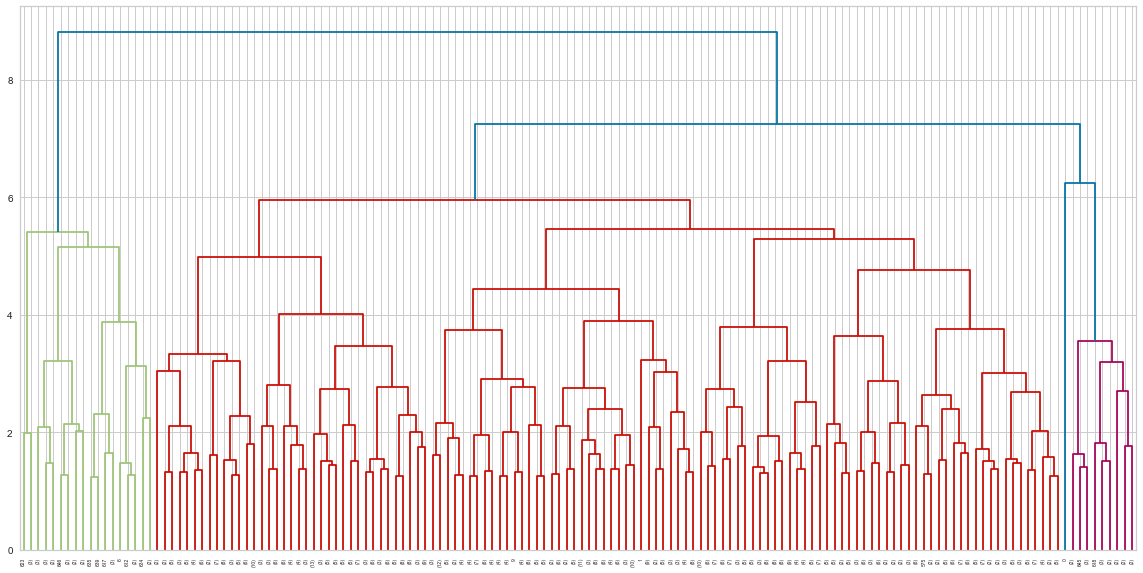

In [66]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z3,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [67]:
clusters3 = fcluster(Z3,7, criterion='distance')
clusters3

array([3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [68]:
# Calculate Avg Silhoutte Score
score3=silhouette_score(subset_scaled_df,clusters3)
compare_silscore.append(['Complete','mahalanobis',score3])

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### Complete and Euclidean

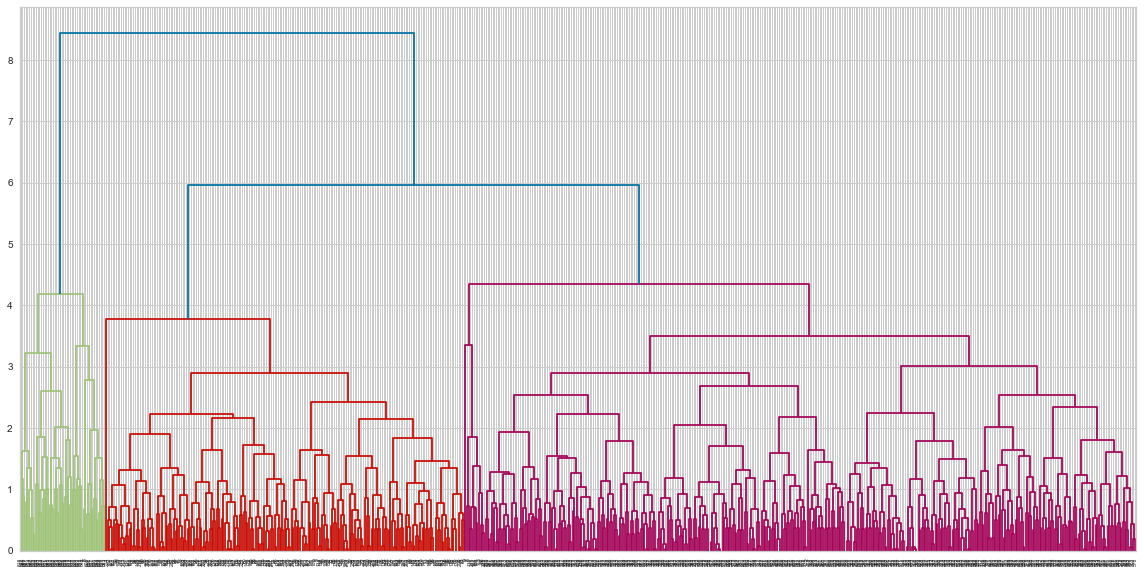

In [69]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
Z4 = linkage(subset_scaled_df, metric='euclidean', method='complete')
dendrogram(Z4);

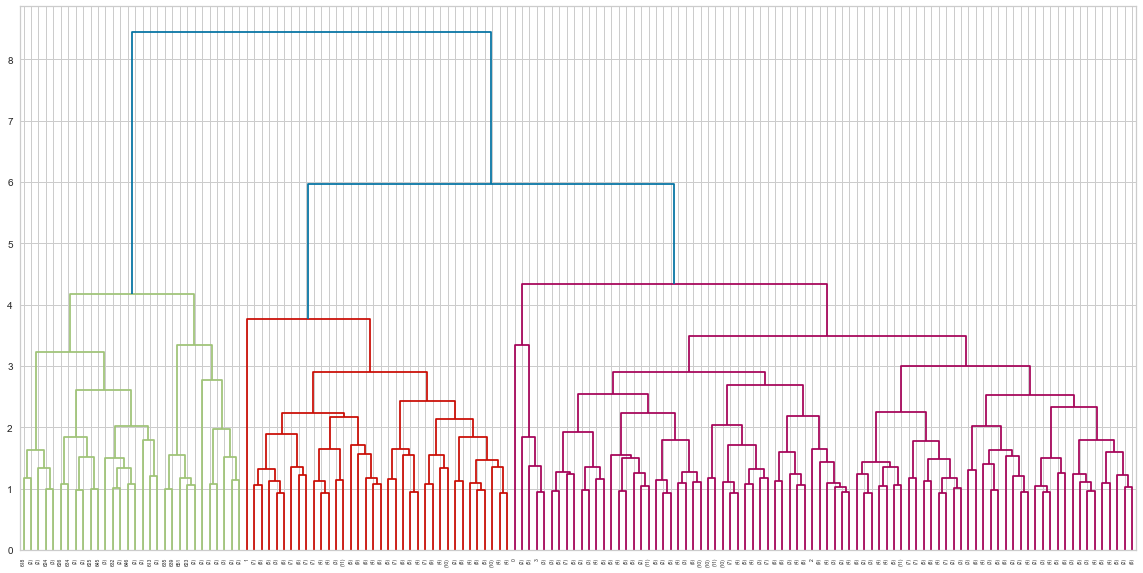

In [70]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z4,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [71]:
clusters4 = fcluster(Z4, 5, criterion='distance')
clusters4

array([3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [72]:
# Calculate Avg Silhoutte Score
score4=silhouette_score(subset_scaled_df,clusters4)
compare_silscore.append(['Complete','Euclidean',score4])

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### ward and Euclidean

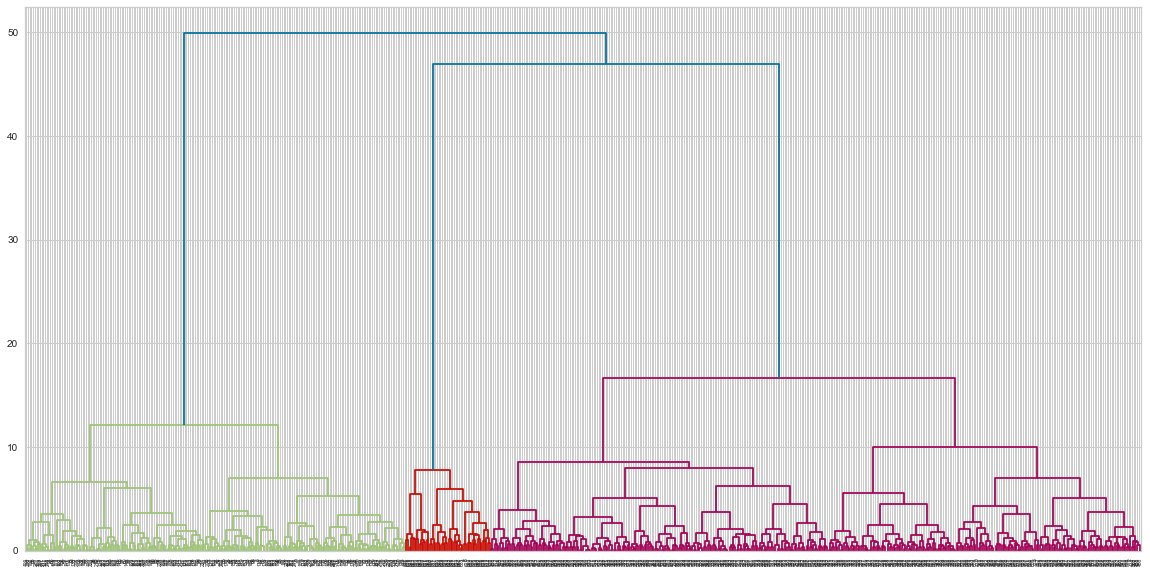

In [73]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
Z5 = linkage(subset_scaled_df, metric='euclidean', method='ward')
dendrogram(Z5);

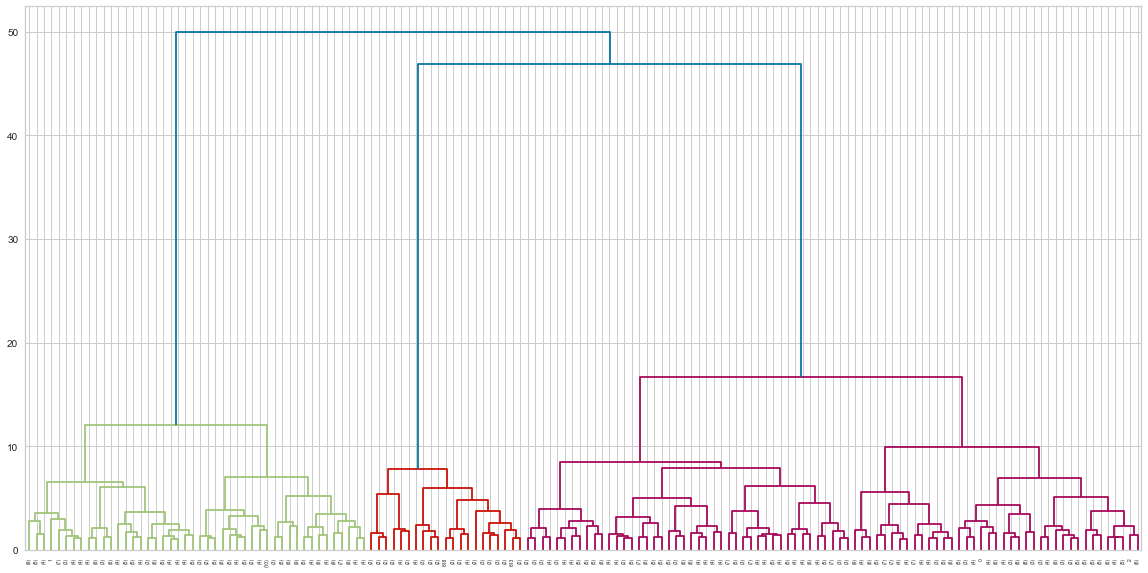

In [74]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z5,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [75]:
clusters5 = fcluster(Z5, 18, criterion='distance')
clusters5

array([3, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### From the original and truncated dendrogram, find out the optimal distance between clusters which u want to use an input for clustering data
#### centroid and Euclidean

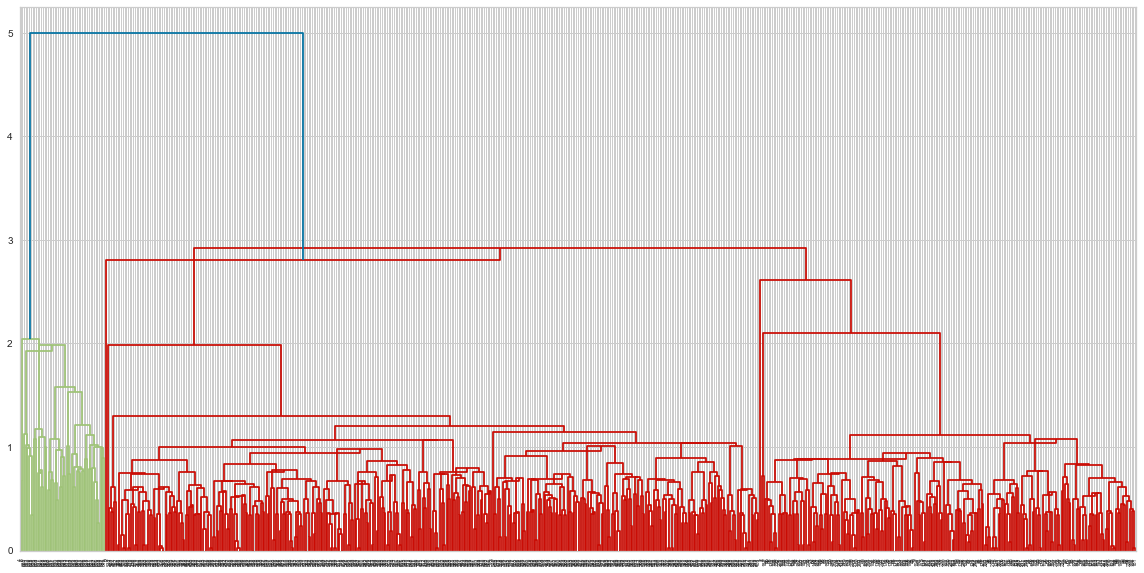

In [76]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
Z6 = linkage(subset_scaled_df, metric='euclidean', method='centroid')
dendrogram(Z6);

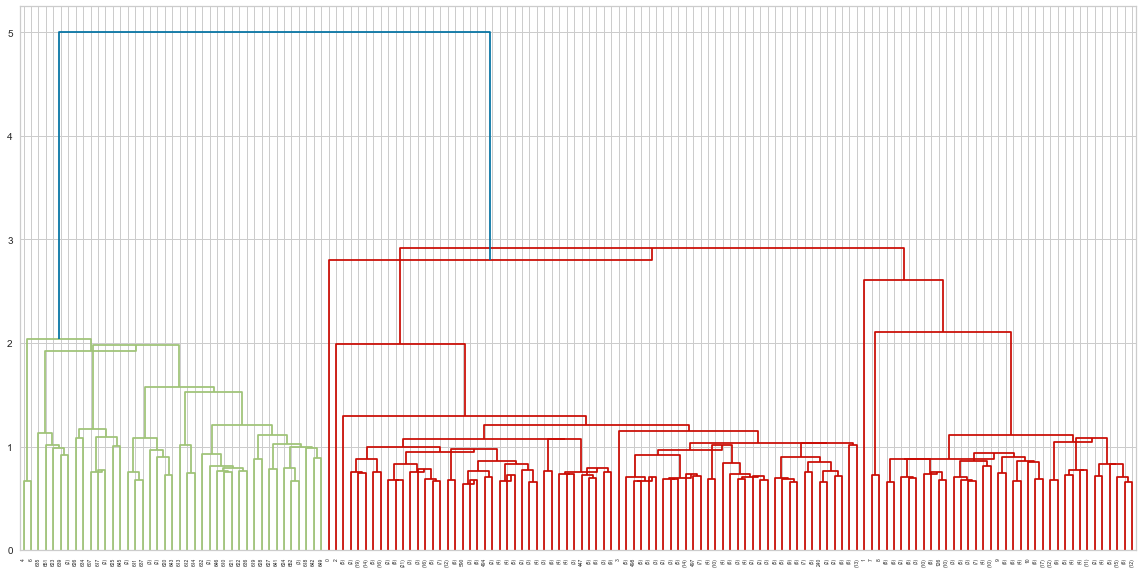

In [77]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z6,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=150,  # show only the last p merged clusters
)
plt.show()

In [78]:
clusters6 = fcluster(Z6, 2.9, criterion='distance')
clusters6

array([4, 3, 2, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [79]:
# Calculate Avg Silhoutte Score
score6=silhouette_score(subset_scaled_df,clusters6)
compare_silscore.append(['Centroid ','Euclidean',score6])

In [80]:
pd.DataFrame(compare_silscore,columns=['Linkage','Metrics','Silhouette Score']).sort_values('Silhouette Score',ascending=False)

,Linkage,Metrics,Silhouette Score
2,Complete,mahalanobis,0.528248
1,Average,cityblock,0.515675
0,Average,Euclidean,0.515028
3,Complete,Euclidean,0.502320
4,Centroid,Euclidean,0.474495


## Final dendogram with 'average linkage' based on Silhouette Score and clear cluster visibility. 
- Silhouette score is better when closer 1 and worse when closer to -1 
- So from here we will choose the Complete method and Average Method

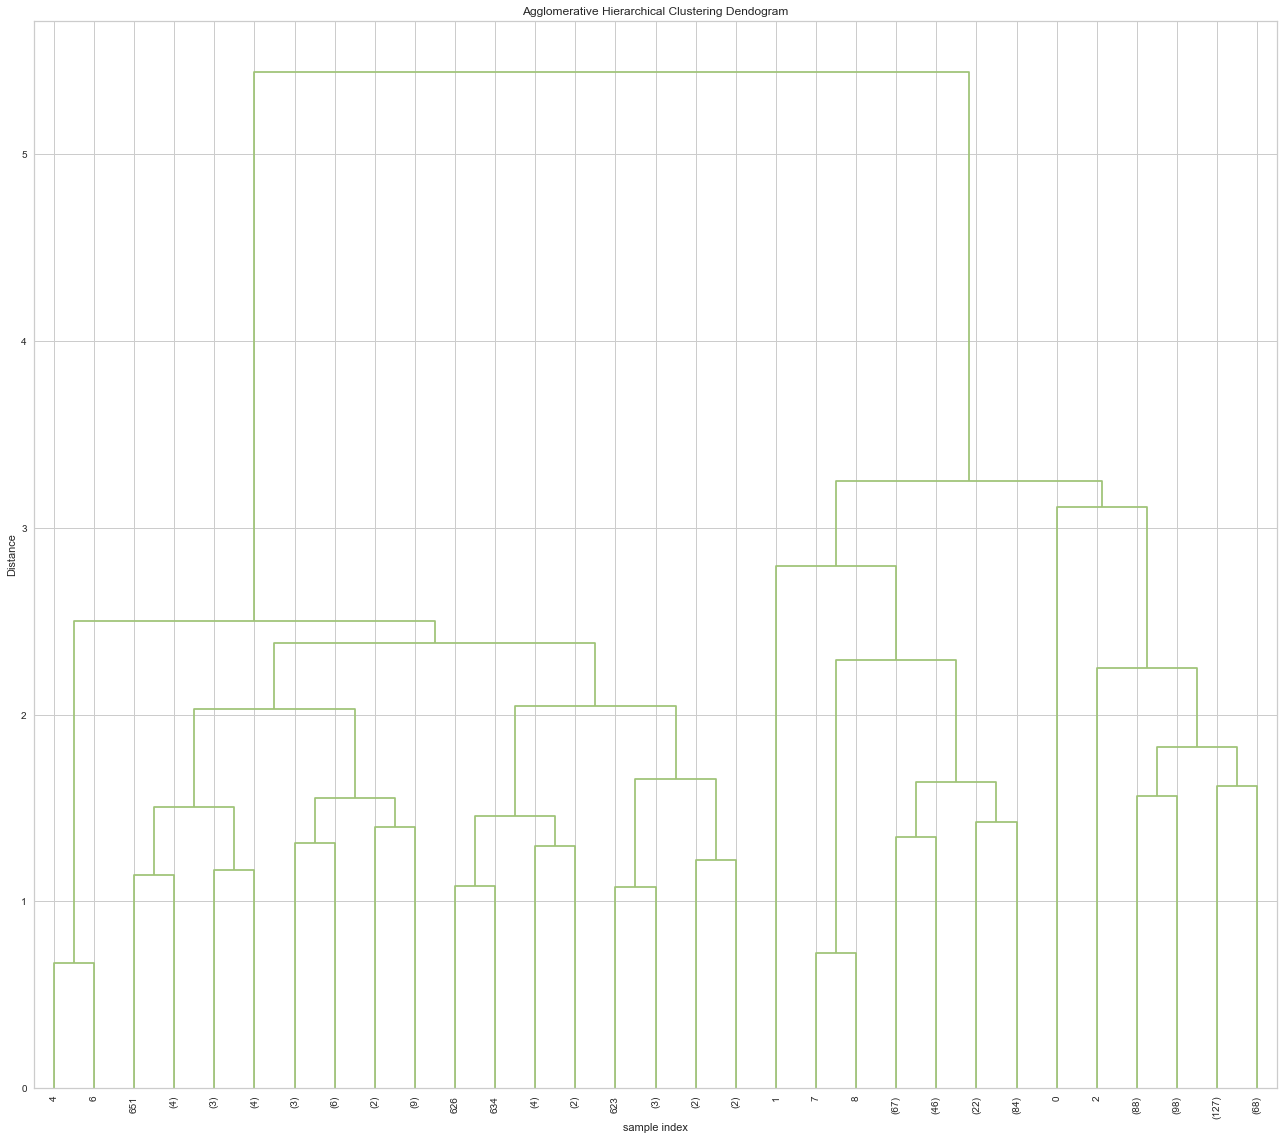

In [81]:
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(subset_scaled_df, 'average')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()

In [82]:
%%time
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='average')
HCmodel.fit(subset_scaled_df)

CPU times: user 15 ms, sys: 1.37 ms, total: 16.4 ms
Wall time: 19.2 ms


AgglomerativeClustering(linkage='average', n_clusters=3)

In [83]:
df_hc['HC_Clusters'] = HCmodel.labels_

In [84]:
cluster_profile_hc = df_hc.groupby('HC_Clusters').mean()

In [85]:
cluster_profile_hc['count_in_each_segment'] = df_hc.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [86]:
# lets display cluster profile
cluster_profile_hc

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,,
0,54884.545692,33793.733681,5.516971,3.485640,0.989556,2.010444,383
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,54985.923423,12283.783784,2.409910,0.932432,3.563063,6.851351,222


- Cluster 1 we can see the average credit limit and total number of credit cards and total visits online is high compared to the other clusters.
- Cluster 2 we can see total calls they are making is high compared to other clusters.
- Cluster 0 we can see their visits to the bank is high

<AxesSubplot:xlabel='HC_Clusters'>

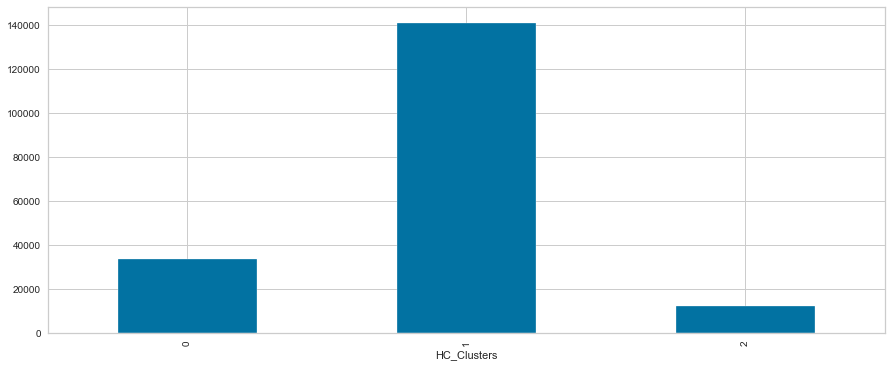

In [87]:
df_hc.groupby('HC_Clusters')['Avg_Credit_Limit'].mean().plot.bar(figsize=(15,6))

- Average Credit Limit is high for cluster 1

<AxesSubplot:xlabel='HC_Clusters'>

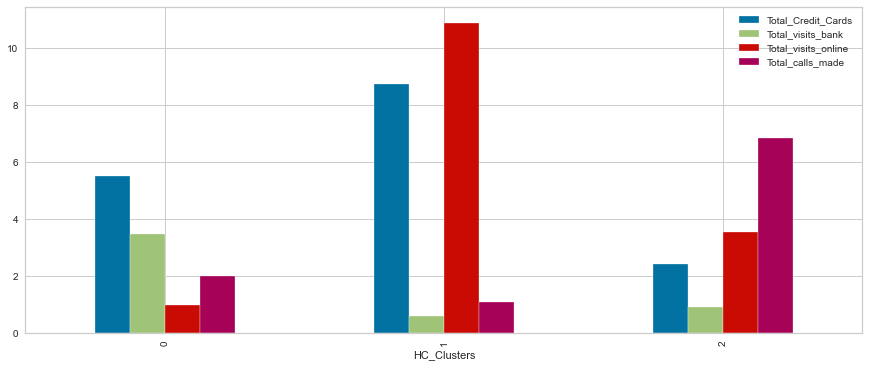

In [88]:
df_hc.groupby('HC_Clusters')['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made'].mean().plot.bar(figsize=(15,6))

- Total # of credit cards and Total visits online are high for cluster 1.
- Total calls made is high for cluster 2
- Total credit cards is higher for cluster 0 compared to cluster 2, but less than cluster 1.
- Total Visits to the bank is high for cluster 0 compared to other clusters.

In [89]:
pd.crosstab(df_hc.HC_Clusters, df_hc['Total_Credit_Cards']).style.highlight_max(color = 'green', axis = 0)

Total_Credit_Cards,1,2,3,4,5,6,7,8,9,10
HC_Clusters,,,,,,,,,,
0,0,1,0,101,72,116,93,0,0,0
1,0,0,0,0,1,1,7,11,11,19
2,59,62,53,47,1,0,0,0,0,0


- Total number of credit cards for cluster 1 is 7 or more
- Total number of credit cards for cluster 2 is 4 or less
- Total number of credit cards for cluster 0 is b/w 4 to 7

In [90]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_Credit_Cards']).plot(kind='bar',stacked=True)

In [91]:
pd.crosstab(df_hc.HC_Clusters, df_hc['Total_visits_bank']).style.highlight_max(color = 'green', axis = 0)

Total_visits_bank,0,1,2,3,4,5
HC_Clusters,,,,,,
0,0,2,94,99,92,96
1,20,30,0,0,0,0
2,79,79,64,0,0,0


- Cluster 0 customers  visits the bank more than other clusters

In [92]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_bank']).plot(kind='bar',stacked=True)

In [93]:
pd.crosstab(df_hc.HC_Clusters, df_hc['Total_visits_online']).style.highlight_max(color = 'green', axis = 0)

Total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
HC_Clusters,,,,,,,,,,,,,,,,
0,142,104,136,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10
2,0,4,51,43,69,54,0,0,0,0,1,0,0,0,0,0


- Cluster 1 customers visit online more compared to other clusters (7+)
- Cluster 2 customers visit online b/w 2-5 times
- Cluster 0 customers have less online visits (<=2)

In [94]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_visits_online']).plot(kind = 'bar', stacked=True)

In [95]:
pd.crosstab(df_hc.HC_Clusters, df_hc['Total_calls_made']).style.highlight_max(color = 'green', axis = 0)

Total_calls_made,0,1,2,3,4,5,6,7,8,9,10
HC_Clusters,,,,,,,,,,,
0,79,74,71,82,77,0,0,0,0,0,0
1,16,15,18,1,0,0,0,0,0,0,0
2,0,1,1,0,31,29,39,35,29,32,25


- Cluster 0 also prefers to make fewer calls but higher than cluster 1
- Cluster 2 prefer to call up the bank compared to other clusters (>6)
- Cluster 1 make fewer calls to the bank comparitively (<3)

In [96]:
#pd.crosstab(df_kmeans.K_means_segments, df_kmeans['Total_calls_made']).plot(kind = 'bar', stacked=True)

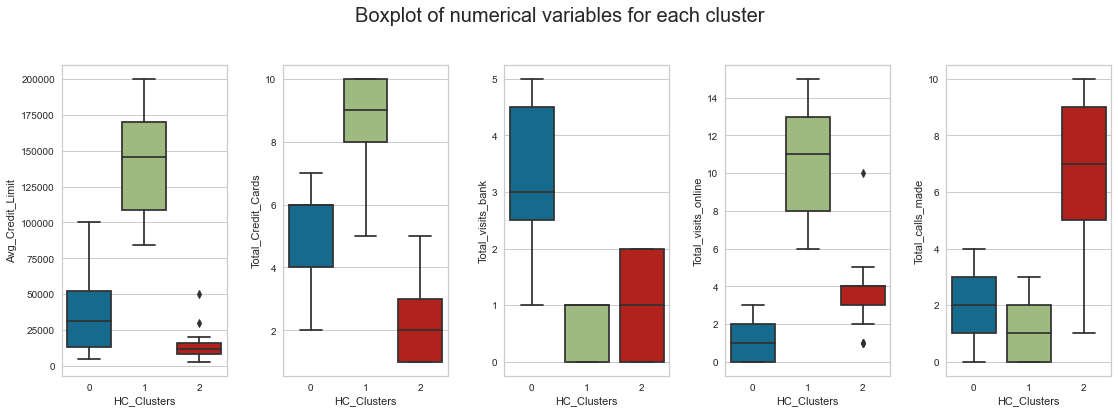

In [97]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df_hc[all_col[counter]],x=df_hc['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

- Cluster 1 are those customers with higher credit limit(avg 140000) having more card (avg 9 cards) with higher visits online compared to visiting banks / calls.
- Cluster 2 are customers with low credit limit (avg 12000) having fewer cards ( avg 2 cards) with high number of calls to the bank compared to online or bank visits.
- Cluster 0 are customers with credit limit (33000 avg) with more cards (avg 5) with higher number of visits to the bank compared to calls or visits online

### Comparing of KMeans vs Hierarchical Clustering (with cluster 3 and 4)

#### KMeans vs Hierarchical clustering with 3 clusters

In [98]:
# lets display cluster profile
cluster_profile_kmeans

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,54801.882507,33853.785901,5.519582,3.483029,0.986945,2.010444,383
1,55128.536036,12180.180180,2.405405,0.936937,3.567568,6.851351,222
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [99]:
cluster_profile_hc

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,,
0,54884.545692,33793.733681,5.516971,3.485640,0.989556,2.010444,383
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,54985.923423,12283.783784,2.409910,0.932432,3.563063,6.851351,222


In [100]:
%%time
preds=KMeans(n_clusters=3, random_state=1).fit(subset_scaled_df)

CPU times: user 71.5 ms, sys: 12.5 ms, total: 84 ms
Wall time: 68.8 ms


In [101]:
print('silhouette score for KMeans with 3 clusters :',silhouette_score(subset_scaled_df, preds.labels_))

silhouette score for KMeans with 3 clusters : 0.5154656016308689


In [102]:
%%time
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='complete')
preds=HCmodel.fit(subset_scaled_df)

CPU times: user 23.5 ms, sys: 4.2 ms, total: 27.7 ms
Wall time: 48.5 ms


In [103]:
print('silhouette score for AgglomerativeClustering with 3 clusters :',silhouette_score(subset_scaled_df, preds.labels_))

silhouette score for AgglomerativeClustering with 3 clusters : 0.5023200437941001


#### KMeans vs Hierarchical clustering with 3 clusters

- Between the two clustering technique we can see the same set of customer profiling
- KMeans clustering seem to be working better in terms of execution time when compared to Hierarchical clustering.
- Silhouette scores for both the clustering technique seems to be almost the same

In [104]:
%%time
kmeans4 = KMeans(n_clusters=4, random_state=1)
kmeans4.fit(subset_scaled_df)

CPU times: user 141 ms, sys: 17.5 ms, total: 158 ms
Wall time: 110 ms


KMeans(n_clusters=4, random_state=1)

In [105]:
print('silhouette score for KMeans with 4 clusters :',silhouette_score(subset_scaled_df, kmeans4.labels_))

silhouette score for KMeans with 4 clusters : 0.35575668204686567


In [106]:
df_kmeans4=df.copy()
df_kmeans4['K_means_segments'] = kmeans4.labels_

In [107]:
cluster_profile_kmeans4 = df_kmeans4.groupby('K_means_segments').mean()

In [108]:
cluster_profile_kmeans4['count_in_each_segment'] = df_kmeans4.groupby('K_means_segments')['Total_Credit_Cards'].count().values
#cluster_profile_kmeans4['count_in_each_segment'] = df_kmeans4.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [109]:
%%time
HCmodel4 = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='complete')
HCmodel4.fit(subset_scaled_df)

CPU times: user 17.3 ms, sys: 2.82 ms, total: 20.1 ms
Wall time: 25.1 ms


AgglomerativeClustering(linkage='complete', n_clusters=4)

In [110]:
print('silhouette score for Agglomerative with 4 clusters :',silhouette_score(subset_scaled_df, HCmodel4.labels_))

silhouette score for Agglomerative with 4 clusters : 0.34020362555902034


In [111]:
df_hc4 = df.copy()
df_hc4['HC_Clusters'] = HCmodel4.labels_

In [112]:
cluster_profile_hc4 = df_hc4.groupby('HC_Clusters').mean()

In [113]:
cluster_profile_hc4['count_in_each_segment'] = df_hc4.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [114]:
cluster_profile_kmeans4

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,55522.101064,31255.319149,5.494681,4.510638,1.021277,1.946809,188
1,55144.474886,12173.515982,2.388128,0.931507,3.589041,6.904110,219
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,54105.358586,36000.000000,5.515152,2.474747,0.969697,2.085859,198


In [115]:
# lets display cluster profile
cluster_profile_hc4

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,,
0,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
1,54800.282723,33620.418848,5.526178,3.492147,0.989529,2.015707,382
2,55201.900474,12241.706161,2.345972,0.962085,3.649289,6.990521,211
3,53862.250000,20333.333333,3.500000,0.416667,1.833333,3.833333,12


#### KMeans vs Hierarchical clustering with 4 clusters

- Between the two clustering technique we can see a different set of cluster profiling emerging with 4 clusters.
- We can see cluster 1 and 2 in KMeans correspond to cluster 0 and2 in Hierarchical clustering. It follows the same trend.
- We can see cluster 0 and 3 in KMeans correspond to cluster 1 and 3 in Hierarchical clustering. It follows the same trend.
- KMeans clustering seem to be working better in terms of execution time when compared to Hierarchical clustering.
- Silhouette scores for both the cluster seems to less than what we got with 3 clusters.

## Checking out the complete linkage and Mahalanabolis Metric which has got the highest silhouette score

In [116]:
%%time
HCmodel_cm = AgglomerativeClustering(n_clusters=3,affinity='mahalanobis', linkage='complete')
HCmodel_cm.fit(subset_scaled_df)

CPU times: user 45.3 ms, sys: 2.88 ms, total: 48.2 ms
Wall time: 43.6 ms


AgglomerativeClustering(affinity='mahalanobis', linkage='complete',
                        n_clusters=3)

In [117]:
df_hc_cm = df.copy()
df_hc_cm['HC_Clusters'] = HCmodel_cm.labels_

In [118]:
cluster_profile_hc_mc = df_hc.groupby('HC_Clusters').mean()

In [119]:
cluster_profile_hc_mc['count_in_each_segment'] = df_hc_cm.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [120]:
# lets display cluster profile
cluster_profile_hc_mc

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,,
0,54884.545692,33793.733681,5.516971,3.485640,0.989556,2.010444,19
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,32
2,54985.923423,12283.783784,2.409910,0.932432,3.563063,6.851351,604


## With Mahalanabolis and Complete Linkage also we can see a similar clustering with 3 different distinct clusters.
- Average Credit Limit  140000 with more visits online
- Average Credit Limit of around 12200 with more calls to the bank
- Average Credit Limit of around 33000 with more visits to the bank

## Checking out the average linkage and cityblock Metric which has got the highest silhouette score

In [121]:
%%time
HCmodel_ac = AgglomerativeClustering(n_clusters=3,affinity='cityblock', linkage='average')
HCmodel_ac.fit(subset_scaled_df)

CPU times: user 18.7 ms, sys: 2.08 ms, total: 20.8 ms
Wall time: 25.5 ms


AgglomerativeClustering(affinity='cityblock', linkage='average', n_clusters=3)

In [122]:
df_hc_ac = df.copy()
df_hc_ac['HC_Clusters'] = HCmodel.labels_

In [123]:
cluster_profile_hc_ac = df_hc.groupby('HC_Clusters').mean()

In [124]:
cluster_profile_hc_ac['count_in_each_segment'] = df_hc_cm.groupby('HC_Clusters')['Total_Credit_Cards'].count().values

In [125]:
# lets display cluster profile
cluster_profile_hc_ac

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_Clusters,,,,,,,
0,54884.545692,33793.733681,5.516971,3.485640,0.989556,2.010444,19
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,32
2,54985.923423,12283.783784,2.409910,0.932432,3.563063,6.851351,604


## With Cityblock and Average Linkage also we can see a similar clustering with 3 different distinct clusters.
- Average Credit Limit  140000 with more visits online
- Average Credit Limit of around 12200 with more calls to the bank
- Average Credit Limit of around 33000 with more visits to the bank

# Business Recommendations

- Customer Profiling should be as below : With different clustering techniques KMeans and Hierarchical clustering we are seeing a similar clustering with 3 different clusters.

- There are one set of customers with average credit limit 140000 having more card (avg 9 cards) with higher visits online compared to visiting banks / calls.
- There is another set of customers with low average credit limit  ( avg 12000) having fewer cards ( avg 2 cards) who prefer to call up the bank compared to online or bank visits.
- There is another set of customers with credit limit (avg 33000) with more cards (avg 5) who prefer to visit the bank compared to online visits or call up the bank.

### The marketing should focus on customer with 3 segments 

* Customers with Higher credit limits (avg 140000) and more visits online (avg 10) and more credit cards (avg 8)
* Customer with Medium Credit Limits (avg 33000) with more bank visits (avg 3.5) and around an average of 5 credit cards
* Customer with Low Credit Limits (avg 120000) with more calls to the bank (avg 7) and less credit cards(avg 2)